In [35]:
%load_ext autoreload
from IPython.core.debugger import set_trace
import os
from collections import defaultdict
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
from torch import autograd
import torch.nn.functional as F
import torchvision
import torchio as tio
from models.v2v import V2VModel
import matplotlib.pyplot as plt
import yaml
from easydict import EasyDict as edict
from utils import video_comparison, video, get_capacity
from celluloid import Camera
from IPython.core.display import HTML
from IPython.core.debugger import set_trace
from losses import DiceScoreBinary, DiceLossBinary
from datasets import create_datasets
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
!nvidia-smi

Fri May 27 10:50:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:02:00.0 Off |                  N/A |
| 57%   85C    P2   182W / 250W |   9900MiB / 12211MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX TIT...  Off  | 00000000:03:00.0 Off |                  N/A |
| 22%   

In [3]:
MAKE_LOGS = False
SAVE_MODEL = False
DEVICE = 'cpu'
plt.rcParams['font.size'] = 20

In [4]:
# logdir = './logs/logs_nG/v2v128-IN_Balanced_segpatch_ps64_ppb500_nG_bs1_pbs8_pov0.8_SFL-d99-g2-lr-1e-3-shuffle-AUG-autocast-XYZ@21.04.2022-17:17:40'
logdir = './logs/logs_nG/v2v128-IN_Balanced_segpatch_ps64_ppb500_nG_bs1_pbs6_pov0.8_BCE250-lr-1e-3-shuffle-AUG-XYZ@19.05.2022-14:24:57'
# logdir = 'logs/logs_segpatch/v2v128_GRID_segpatch_ps64_BRATS_bs1_pbs8_pov0.9_lr-1e-3@01.03.2022-03:24:37'

In [5]:
os.listdir(logdir)

['tb', '.config.yaml.swp', 'best_val_preds', 'config.yaml', 'checkpoints']

In [8]:
val_preds_path = os.path.join(logdir, 'best_val_preds')
checkpoint_path = os.path.join(logdir, 'checkpoints')
os.listdir(checkpoint_path)

['weights_5.pth',
 'weights_4.pth',
 'weights_2.pth',
 'weights_0.pth',
 'weights_1.pth',
 'weights_3.pth']

In [9]:
weights_path = os.path.join(logdir, 'checkpoints/weights_5.pth')
weights = torch.load(weights_path)

In [10]:
for k,v in weights['model_state'].items():
    break

In [12]:
os.listdir(val_preds_path)

['n5', 'n70', 'n78', 'G324', 'n66', 'n11', 'G414', 'n15', 'G258']

In [13]:
with open(os.path.join(logdir, 'config.yaml')) as fin:
    config = edict(yaml.safe_load(fin))

In [14]:
config

{'make_logs': True,
 'comment': 'Percentile clipping for tensors_nG',
 'opt': {'device': 3,
  'criterion': 'BCE',
  'bce_pos_weight': 250,
  'bce_neg_weight': 1,
  'delta': 0.9,
  'gamma': 2,
  'weight': 0.5,
  'use_scaler': False,
  'start_epoch': 0,
  'n_epochs': 9999,
  'augmentation': True,
  'train_batch_size': 1,
  'val_batch_size': 1,
  'lr': 0.001,
  'save_model': True},
 'model': {'name': 'v2v',
  'output_channels': 1,
  'max_channel_encoder_decoder': 128,
  'sigmoid': True,
  'normalization': 'instance_norm',
  'activation': 'LeakyReLU',
  'use_greedy_saving': False,
  'target_metric_name': 'dice_score'},
 'dataset': {'save_best_val_predictions': True,
  'trim_background': True,
  'patch_overlap': 0.8,
  'features': ['curv',
   'sulc',
   'thickness',
   'bT1',
   'bT2',
   'T1w',
   'CSF',
   'GM',
   'WM',
   'cr',
   'entropy'],
  'add_xyz': True,
  'root': '/nfs/tom/ibulygin/fcd_data/tensors_nG',
  'metadata_path': 'metadata/metadata_fcd_nG.npy',
  'dataset_type': 'fcd',


In [15]:
# # config.dataset.dataset_type = 'brats'
# # config.dataset.metadata_path = './metadata/metadata_brats2020.npy'

# config.dataset.dataset_type = 'fcd'
# config.dataset.metadata_path = './metadata/metadata_fcd_nG.npy'

### Load model, setup dataloaders

In [16]:

# essential for the proper samplers functioning
assert config.opt.val_batch_size == 1
assert config.opt.train_batch_size == 1
device = torch.device(DEVICE)

#########
# MODEL #
#########
# if config.model.name == "v2v":
#     model = V2VModel(config).to(device)
# elif config.model.name == "unet3d":
#     model = UnetModel(config).to(device)
    
# model_dict = torch.load(os.path.join(logdir, 'checkpoints/weights_0.pth'))
# print(f'LOADING from {logdir} \n epoch:', model_dict['epoch'])
# model.load_state_dict(model_dict['model_state'])


###################
# CREATE DATASETS #
###################
train_dataset, val_dataset = create_datasets(config)
collate_fn = None
train_dataloader = DataLoader(train_dataset,
                                batch_size=config.opt.train_batch_size,
                                shuffle=False,
                                collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset,
                            batch_size=config.opt.val_batch_size,
                            shuffle=False,
                            collate_fn=collate_fn)
print(len(train_dataloader), len(val_dataloader))

print('val dataloder len: ', len(val_dataloader), 'train dataloder len: ', len(train_dataloader))

64 9
val dataloder len:  9 train dataloder len:  64


### Load pre-calculated results

In [17]:
best_val_preds = {}
for label in os.listdir(val_preds_path):
    val_preds_label_path = os.path.join(val_preds_path, label)
    best_val_preds[label] = torch.load(val_preds_label_path)[0,0]

In [18]:
dataloader = val_dataloader
labels = dataloader.dataset.labels

In [19]:
best_val_preds.keys()

dict_keys(['n5', 'n70', 'n78', 'G324', 'n66', 'n11', 'G414', 'n15', 'G258'])

In [280]:
# ind = labels.index('G414')
# brain, mask, label_gt = val_dataloader.dataset.__getitem__(ind)

In [249]:
# label = '031'
# brain = brain[0]
# label_gt = label_gt[0]
# label_pred = best_val_preds[label]

# fig, ax = plt.subplots(1,2, sharex=True, sharey=True, dpi=300)
# X_max, Y_max, Z_max = brain.shape

# y_slice_pos = label_gt.sum(axis=(0,-1)).argmax()

# brain_slice = brain[:,y_slice_pos,:]
# ax[0].imshow(brain_slice, 'gray')
# ax[0].imshow(label_gt[:,y_slice_pos,:], 'jet', interpolation='none', alpha=0.5)
# ax[0].set_title('Ground-truth')

# ax[1].imshow(brain_slice, 'gray')
# ax[1].imshow(label_pred[:,y_slice_pos,:], 'jet', interpolation='none', alpha=0.5)
# ax[1].set_title('Predicted')

# # fig.suptitle(f'Label: {label}')

# # plt.colorbar()

# plt.show()

In [52]:
# patch_size = config.dataset.patch_size
# patch_batch_size = config.dataset.patch_batch_size
# patch_overlap = config.dataset.patch_overlap

# pov = int(patch_size*0.4) # take high overlap to avoid missing
# if pov%2!=0:
#     pov+=1

In [250]:
# def get_patch_preds(model, 
#                     brain_tensor, 
#                     mask_tensor, 
#                     label_tensor, 
#                     pov, 
#                     patch_batch_size):
    
#     subject = tio.Subject(t1=tio.ScalarImage(tensor=brain_tensor[0]),
#                                   mask=tio.LabelMap(tensor=mask_tensor[0]),
#                                   label=tio.LabelMap(tensor=label_tensor[0]))

#     grid_sampler = tio.inference.GridSampler(subject, patch_size, pov)
#     patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=patch_batch_size, shuffle=True)
#     aggregator = tio.inference.GridAggregator(grid_sampler, overlap_mode='average')
#     print(len(patch_loader))
#     for patch_i, patches_batch in enumerate(tqdm(patch_loader)):

#         inputs = patches_batch['t1'][tio.DATA].to(device)  # [bs,C,p,p,p]
#         targets = patches_batch['label'][tio.DATA].to(device) # [bs,1,p,p,p]
                    
#         logits = model(inputs)
#         locations = patches_batch[tio.LOCATION]
#         aggregator.add_batch(logits.detach(), locations)
    
#     output_tensor = aggregator.get_output_tensor().unsqueeze(1).to(device) # [1,1,H,W,D]
#     output_tensor = output_tensor * mask_tensor # zeros all non mask values
    
#     return output_tensor

In [20]:
brains = {}
labels_gt = {}
masks = {}
labels_predicted = {}

metric_dict = defaultdict(dict)

iterator = enumerate(val_dataloader)
labels = val_dataloader.dataset.labels

with torch.no_grad():

    # bs = 1
    # brain_tensor - [1,C,H,W,D]
    # mask_tensor - [1,1,H,W,D]
    # label_tensor - [1,1,H,W,D]
    
    #######################
    # ITERATE OVER BRAINS #
    #######################
    for iter_i, (brain_tensor, mask_tensor, label_tensor) in tqdm(iterator):
        
        label = labels[iter_i]
        
        brain_tensor = brain_tensor.to(device)
        mask_tensor = mask_tensor.to(device)
        label_tensor = label_tensor.to(device)
        
#         label_tensor_predicted = get_patch_preds(model, 
#                                                 brain_tensor, 
#                                                 mask_tensor, 
#                                                 label_tensor, 
#                                                 pov, 
#                                                 patch_batch_size)
        
        label_tensor_predicted = torch.tensor(best_val_preds[label][None,None,...])
        
        dice_score = DiceScoreBinary(label_tensor_predicted, label_tensor)
        coverage = (label_tensor_predicted*label_tensor).sum() / label_tensor.sum()
        
        print(dice_score, coverage)
        
        metric_dict['coverage'][label] = coverage.item()
        metric_dict['dice_score'][label] = dice_score.item()
        
        brains[label] = brain_tensor[0].detach().cpu().numpy()
        labels_gt[label] = label_tensor[0,0].detach().cpu().numpy()
        labels_predicted[label] = label_tensor_predicted[0,0].detach().cpu().numpy()
        masks[label] = mask_tensor[0,0].detach().cpu().numpy()
        

1it [00:05,  5.88s/it]

tensor(0.0013) tensor(1.)


2it [00:11,  5.73s/it]

tensor(0.0009) tensor(1.)


3it [00:17,  5.70s/it]

tensor(0.0031) tensor(1.)


4it [00:22,  5.74s/it]

tensor(0.0016) tensor(1.)


5it [00:29,  5.92s/it]

tensor(0.0005) tensor(1.)


6it [00:35,  5.92s/it]

tensor(0.0007) tensor(1.)


7it [00:40,  5.80s/it]

tensor(0.0077) tensor(1.)


8it [00:51,  7.41s/it]

tensor(0.0017) tensor(1.)


9it [00:57,  6.35s/it]

tensor(0.0010) tensor(1.)


In [21]:
np.mean(list(metric_dict['dice_score'].values()))

0.002056407263605959

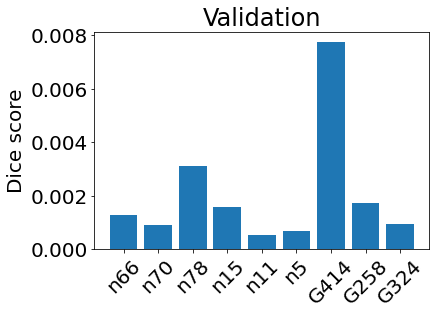

In [22]:
plt.ion()
plt.figure()
plt.bar(metric_dict['dice_score'].keys(), metric_dict['dice_score'].values())
exp_name = logdir.split('/')[1]
plt.title(f'Validation')
plt.ylabel('Dice score')
plt.xticks(rotation=45)
plt.show()

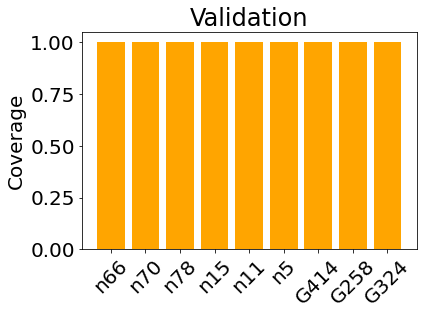

In [23]:
plt.ion()
plt.figure()
plt.bar(metric_dict['coverage'].keys(), metric_dict['coverage'].values(), color='orange')
exp_name = logdir.split('/')[1]
plt.title(f'Validation')
plt.ylabel('Coverage')
plt.xticks(rotation=45)
plt.show()

In [24]:
dices = np.array(list(metric_dict['dice_score'].values()))
labels = np.array(list(metric_dict['dice_score'].keys()))

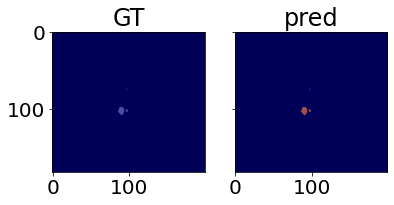

In [25]:
label = 'n5'

plt.ioff()
camera = video_comparison([brains[label][1], brains[label][1]], 
                          [labels_gt[label], best_val_preds[label]], 
                          titles=['GT', 'pred'],
                          n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

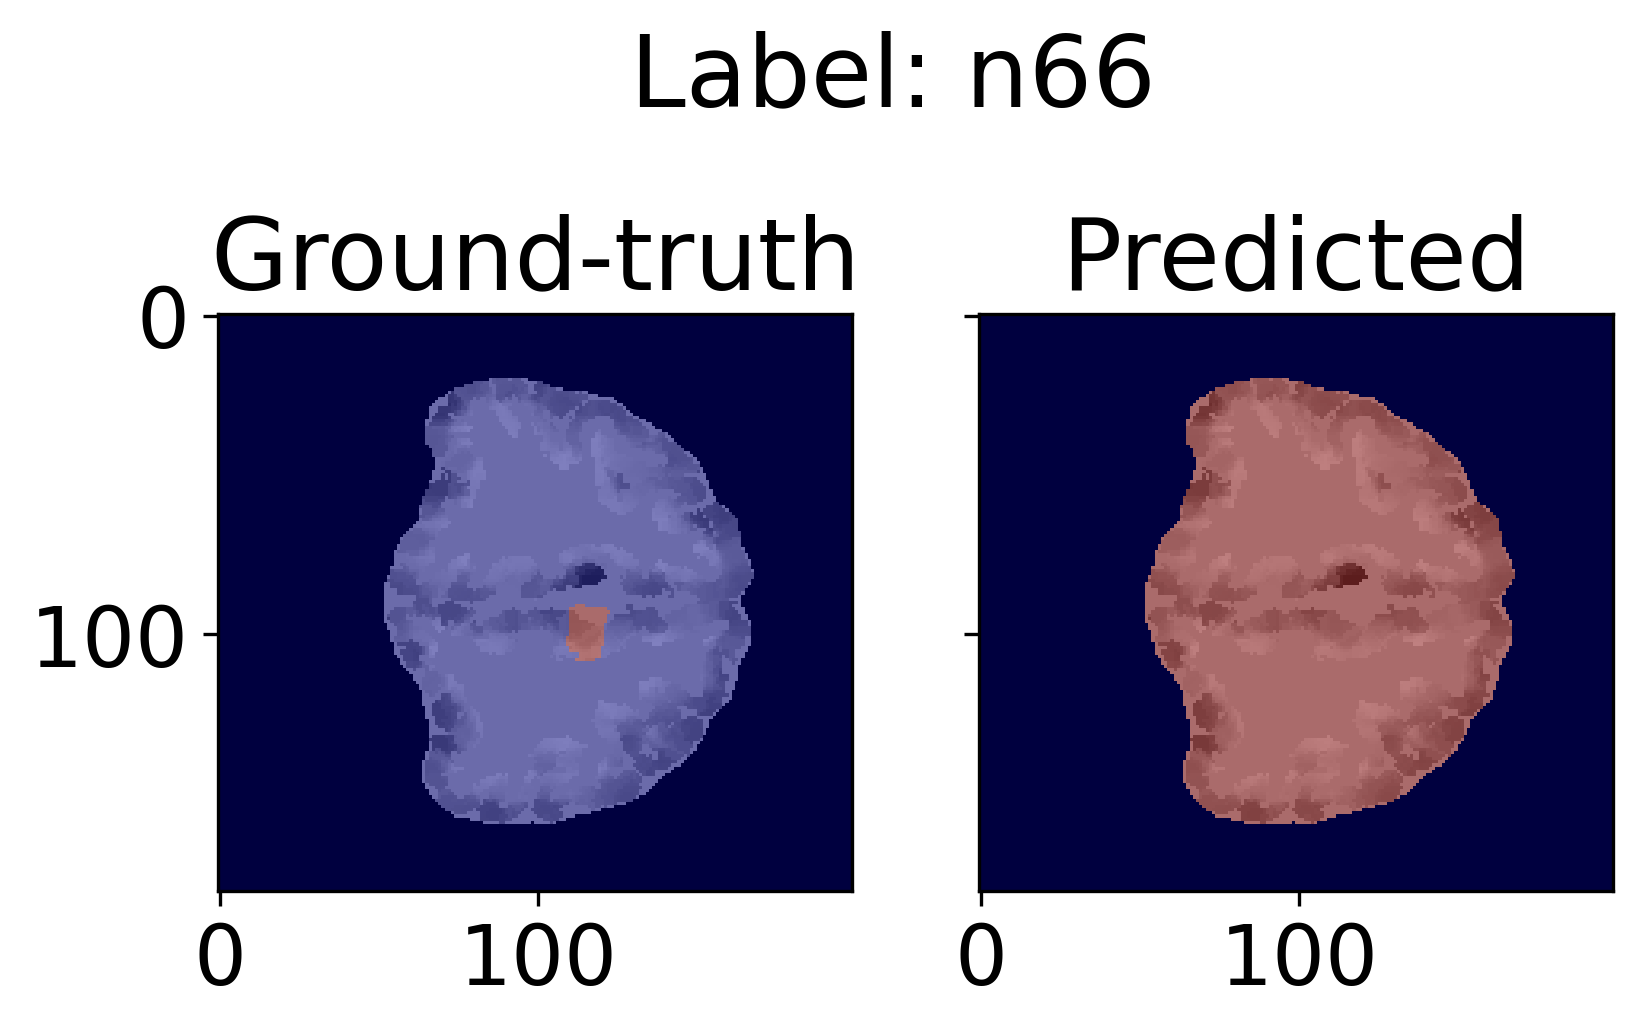

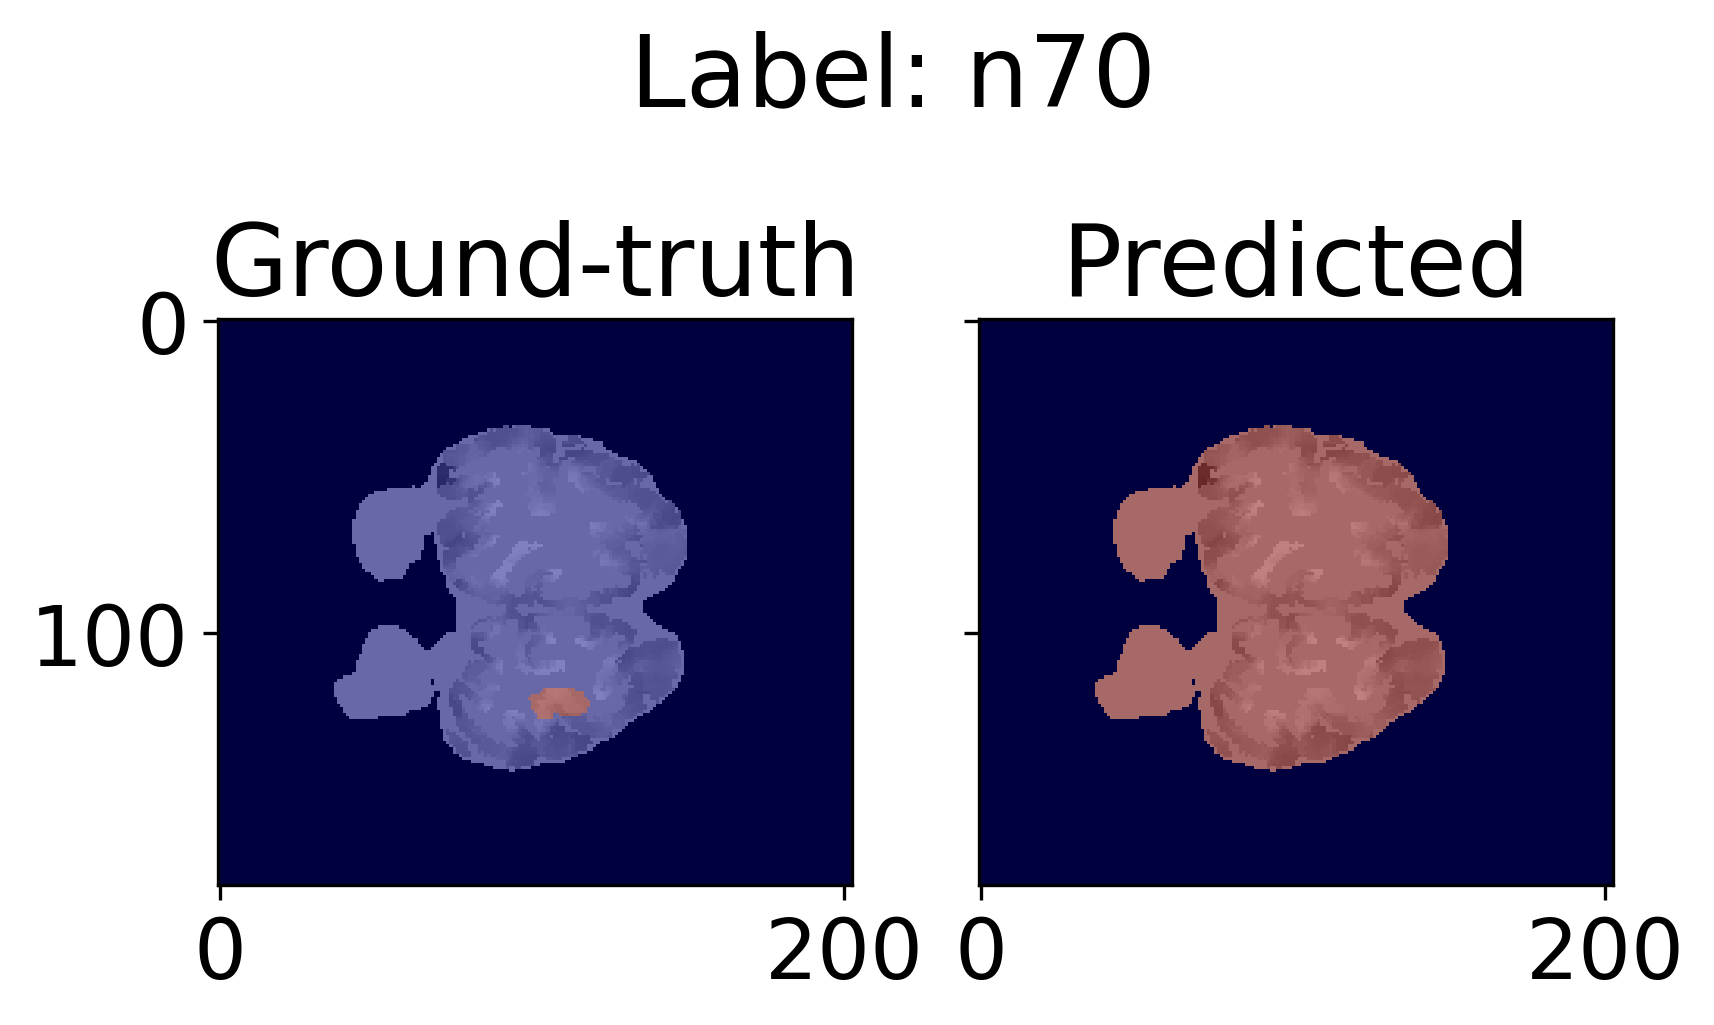

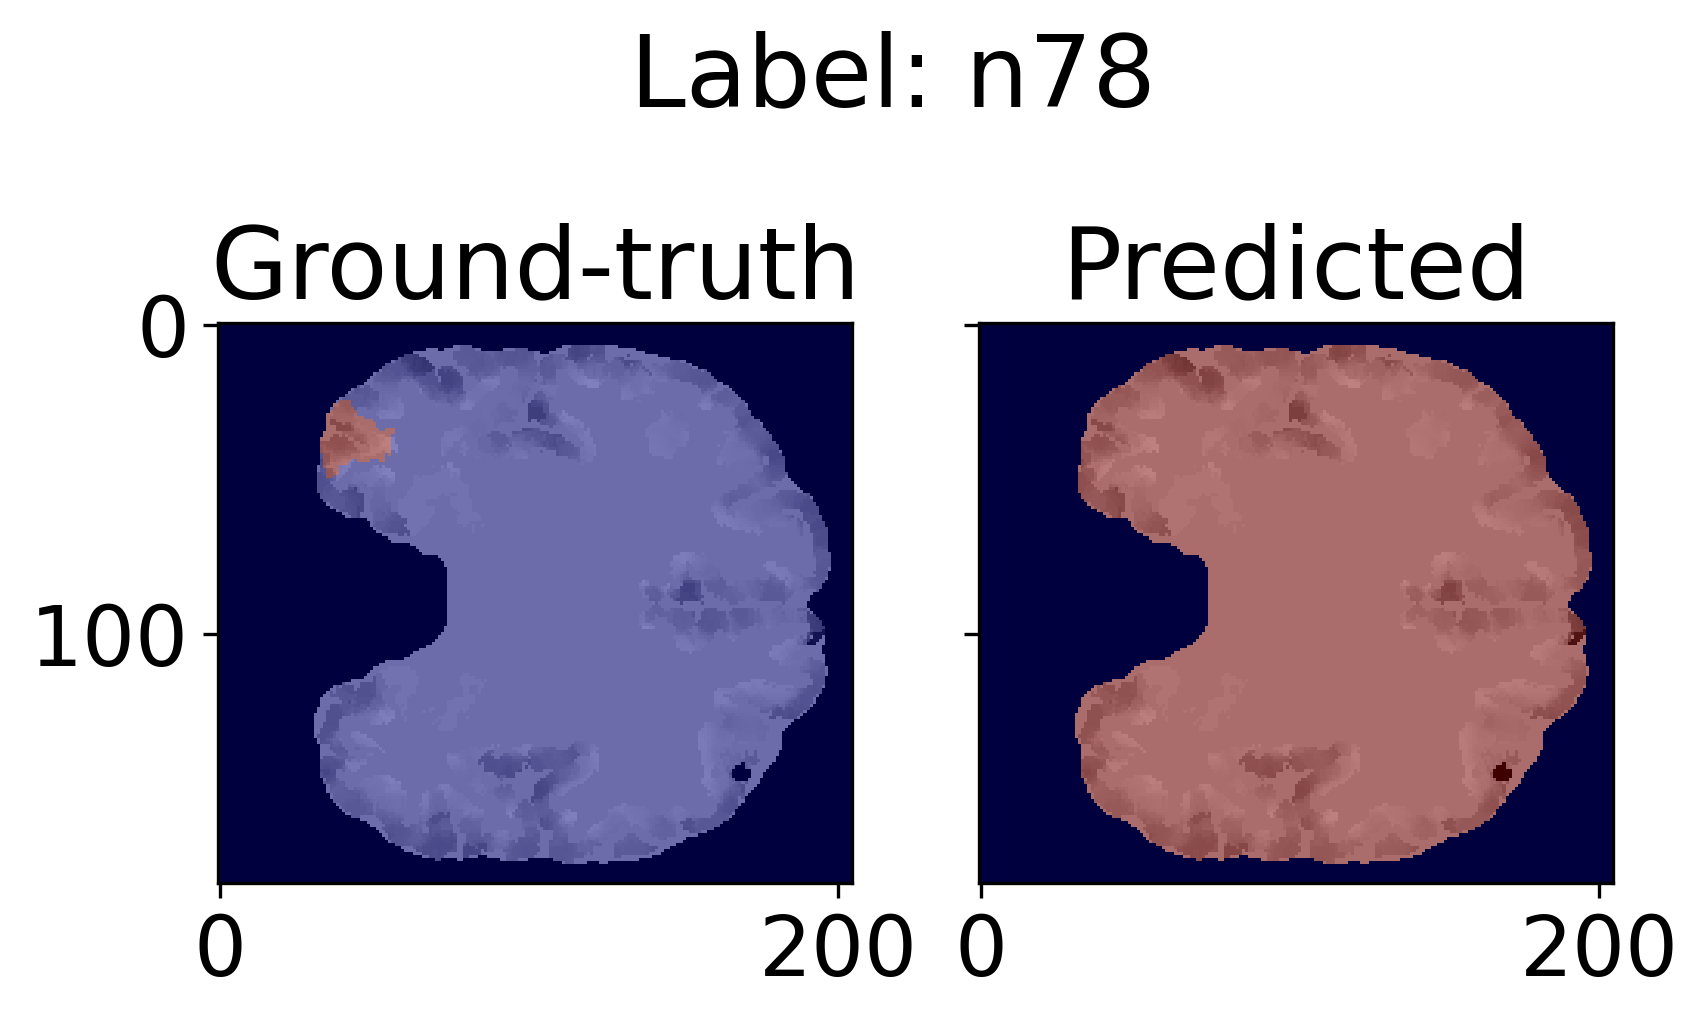

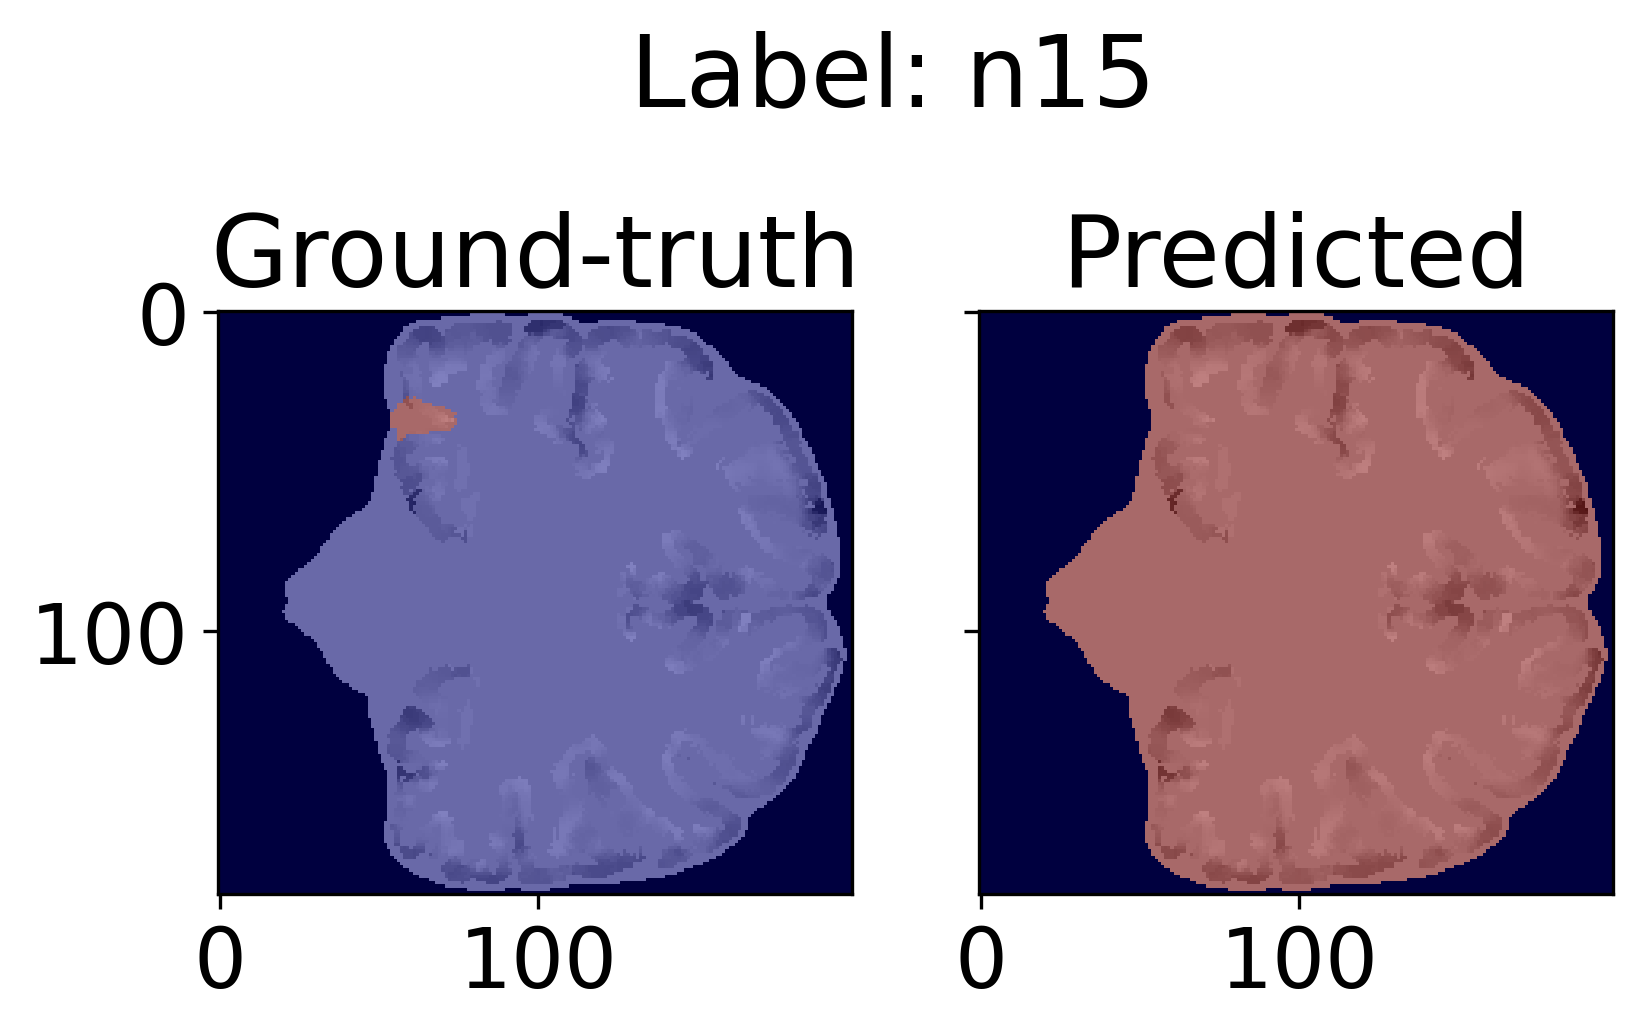

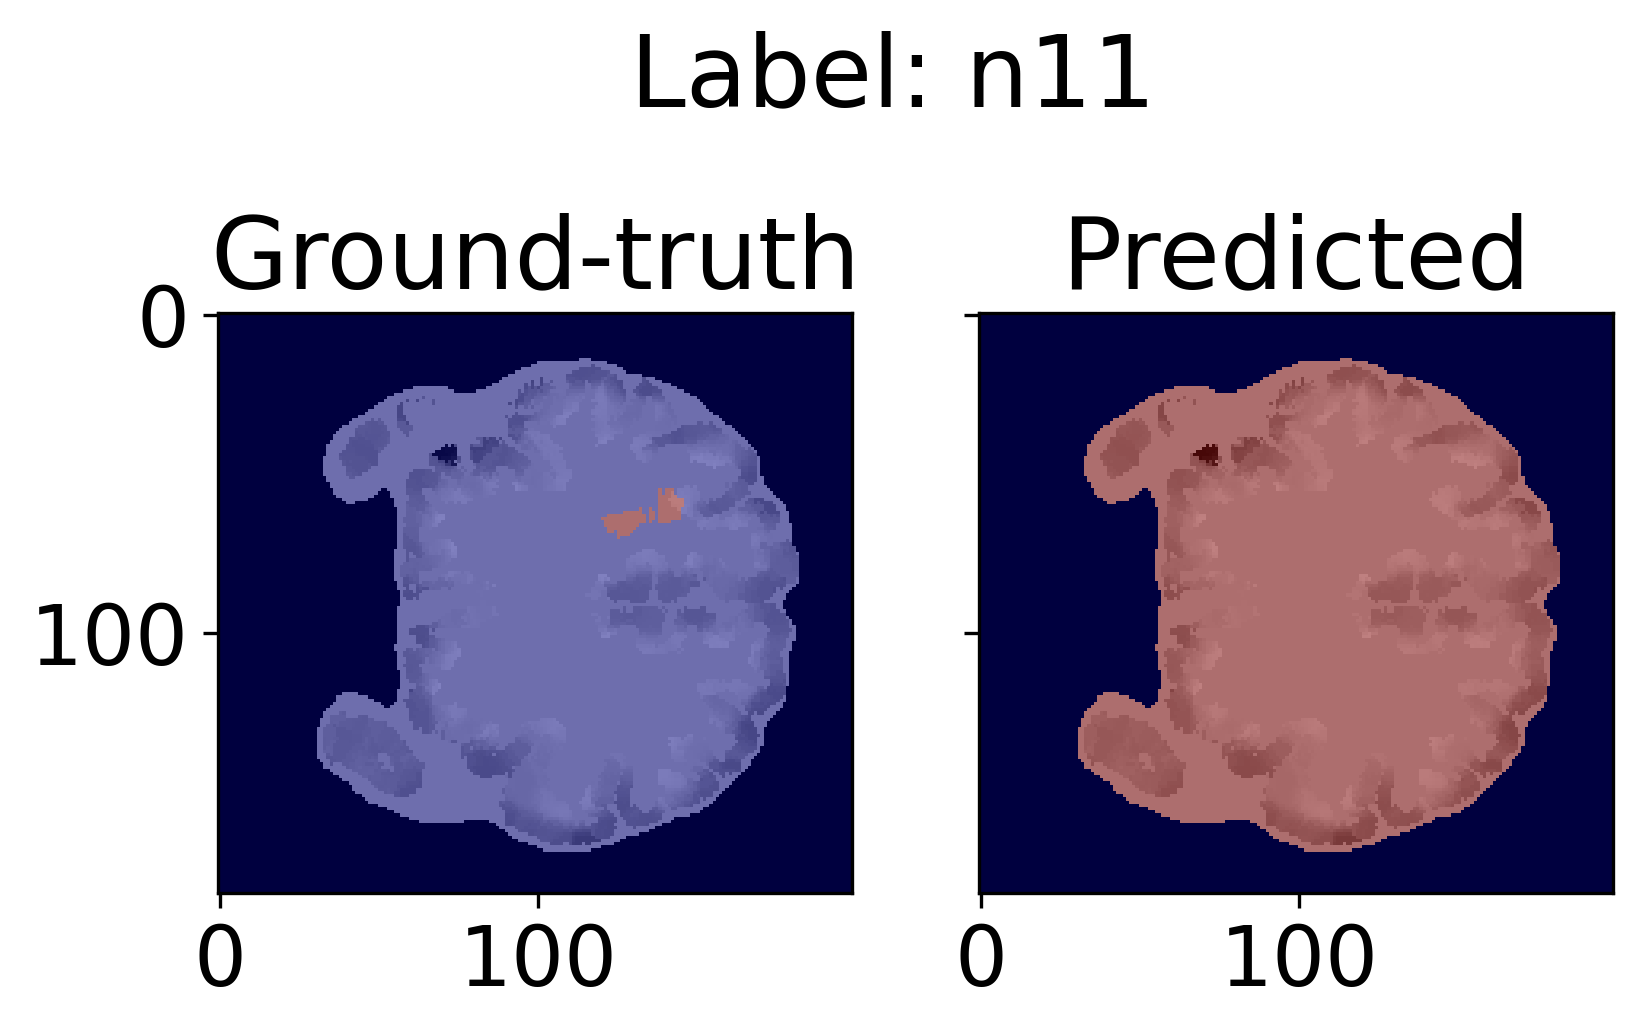

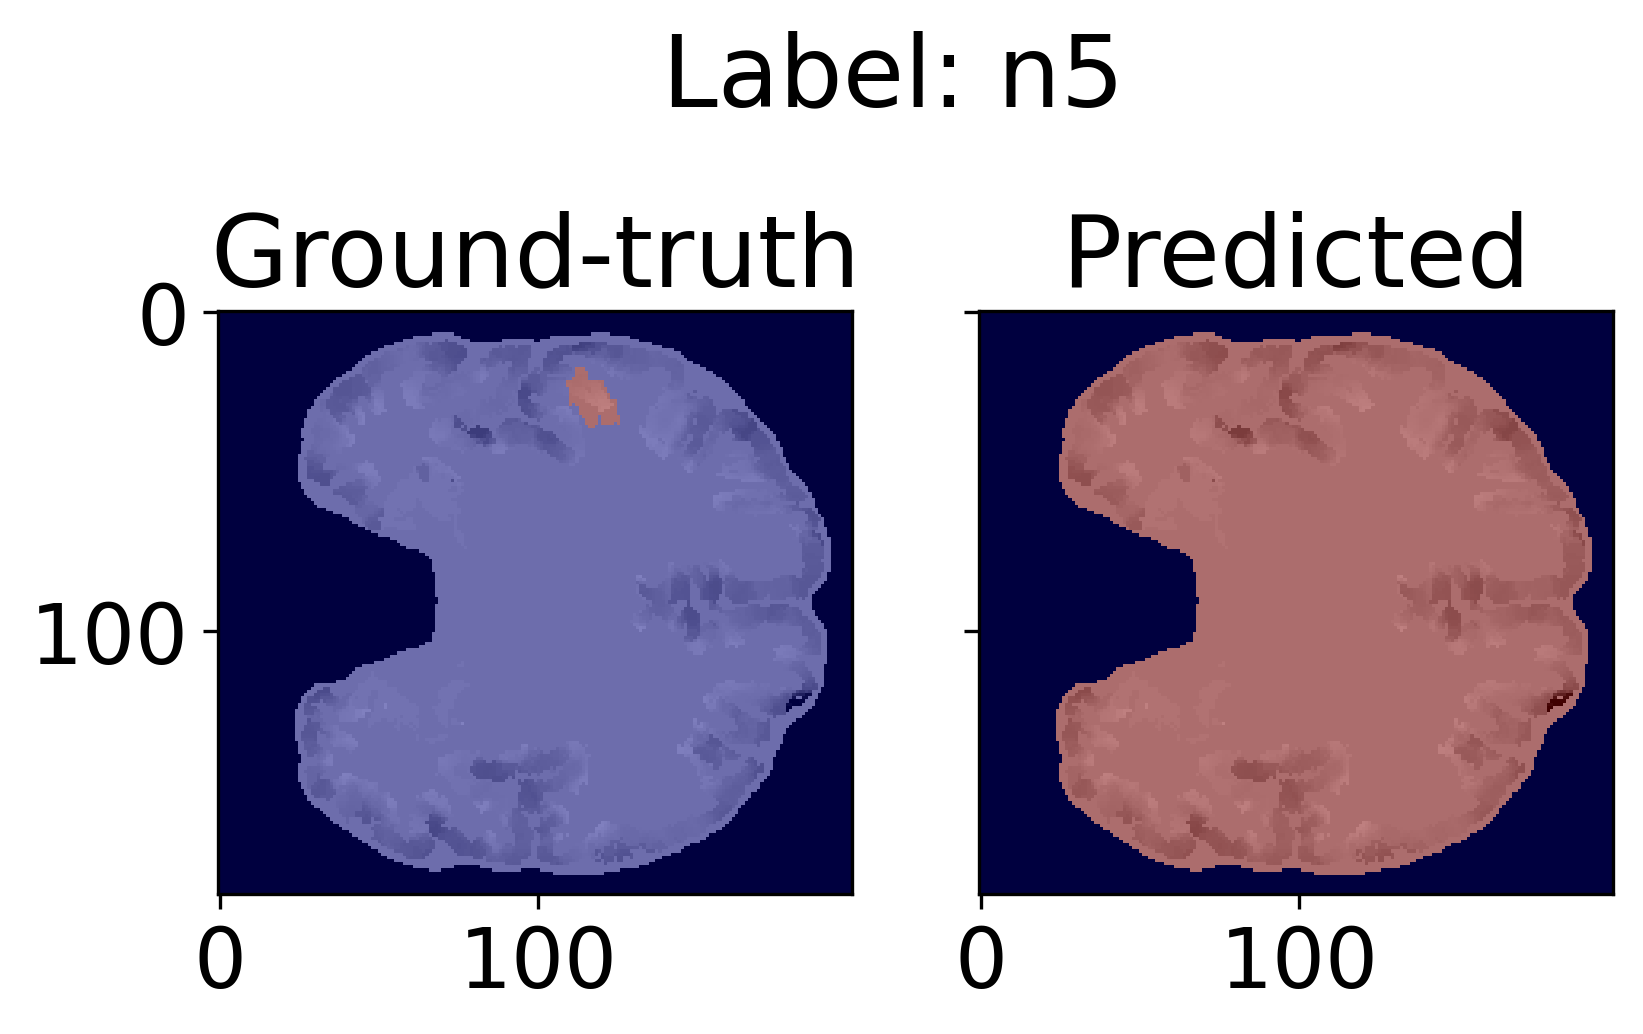

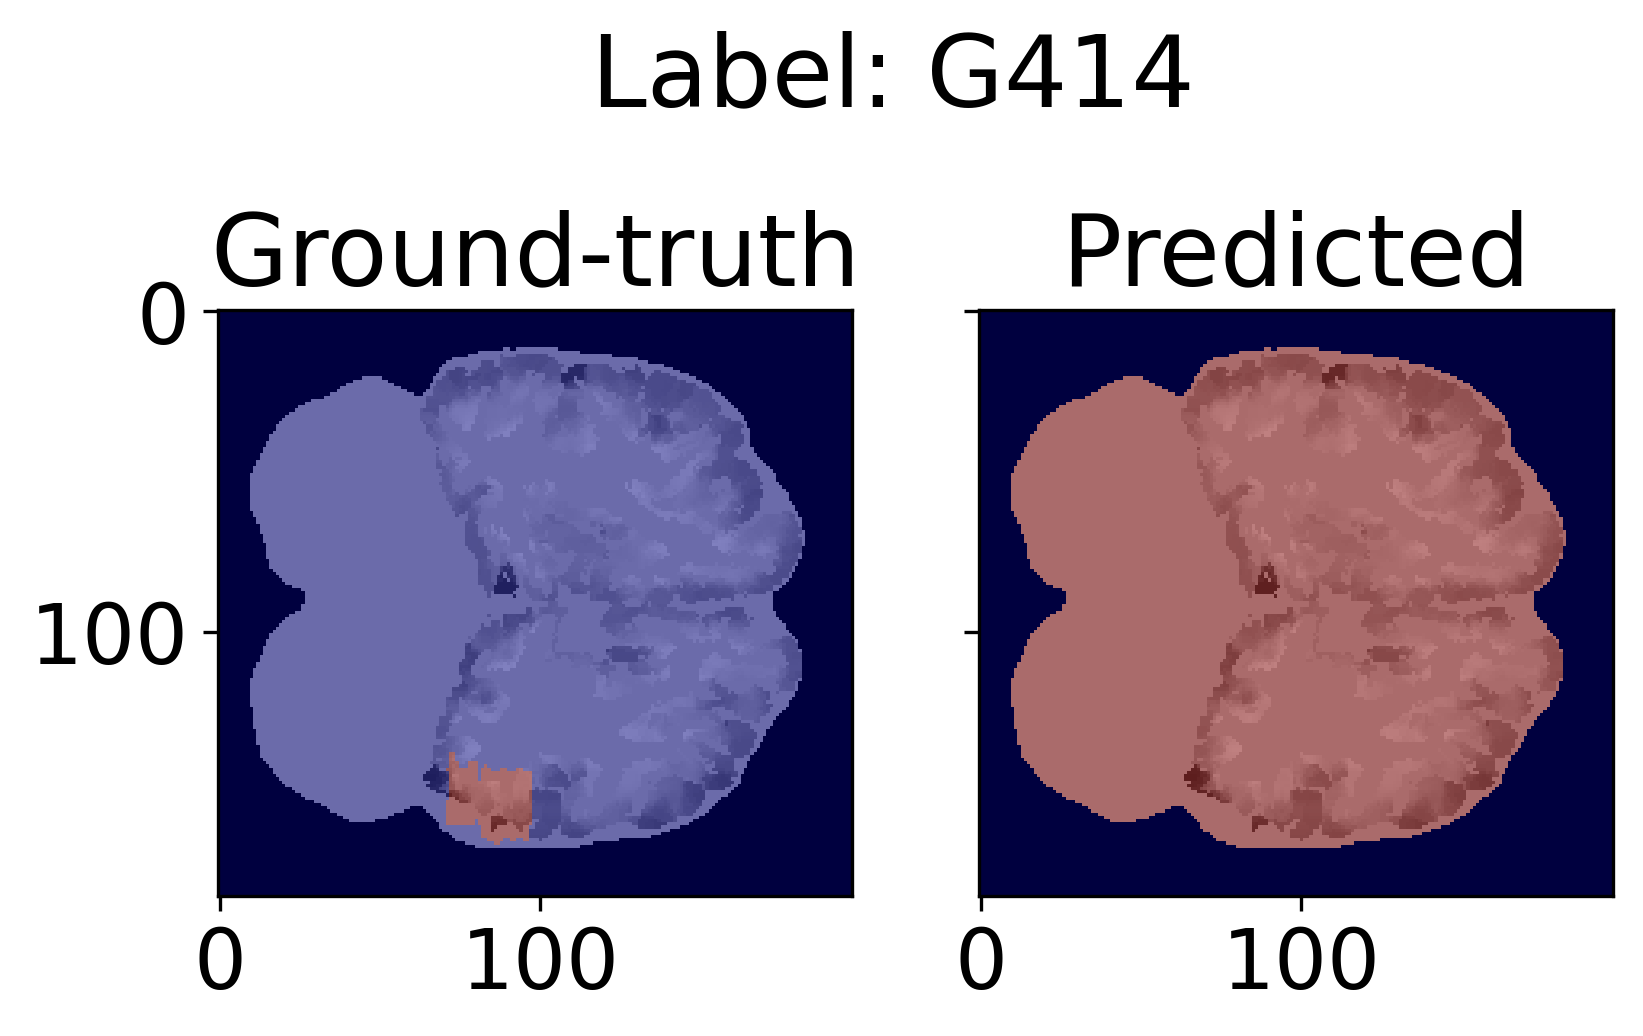

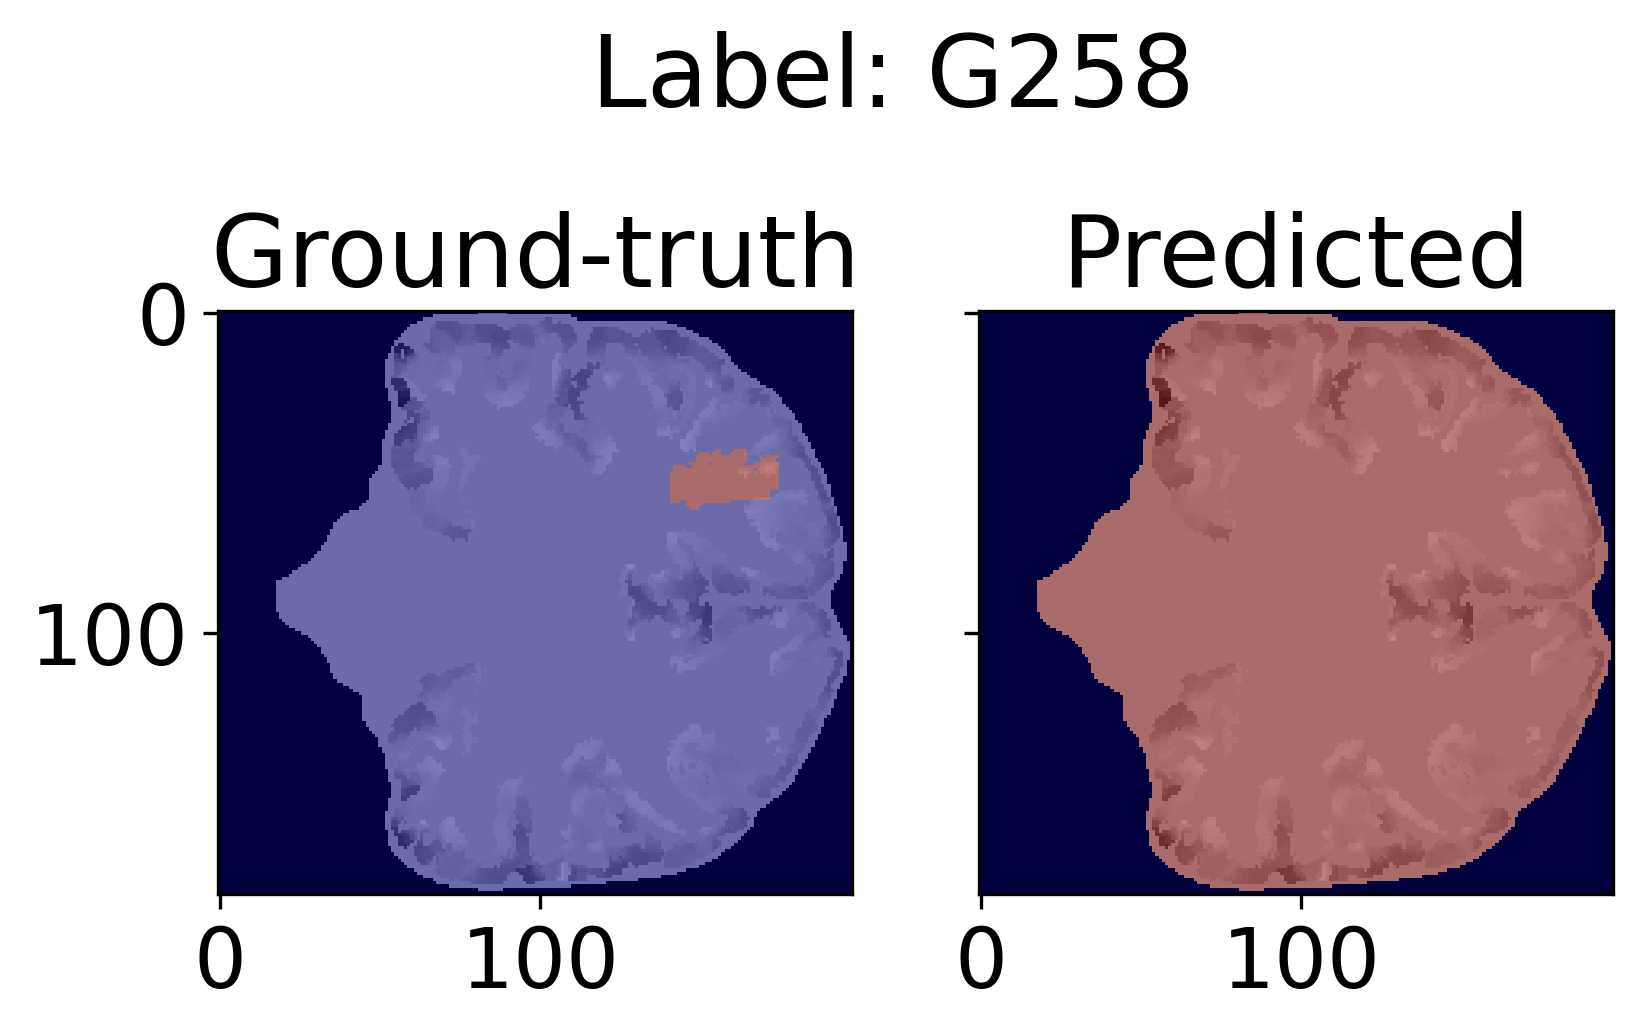

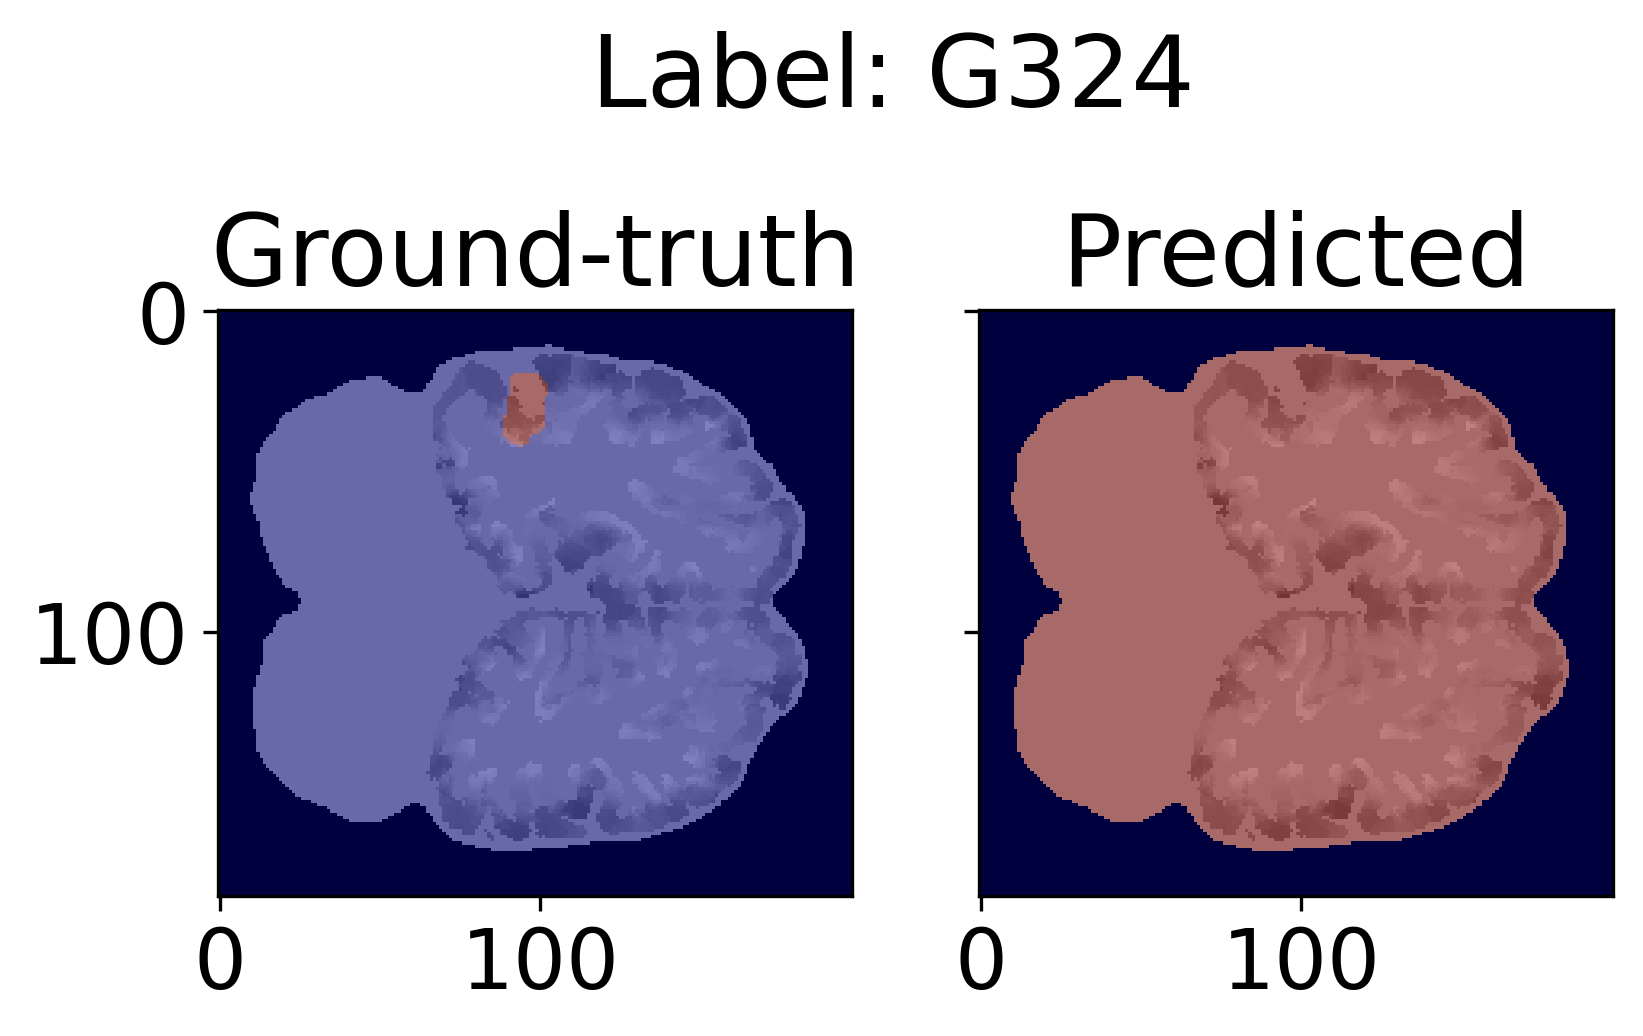

In [26]:
# label = 'G258'

for label in labels:

    brain = brains[label][0]
    label_gt = labels_gt[label]
    label_pred = labels_predicted[label]

    fig, ax = plt.subplots(1,2, sharex=True, sharey=True, dpi=300)
    X_max, Y_max, Z_max = brain.shape

    y_slice_pos = label_gt.sum(axis=(0,-1)).argmax()

    brain_slice = brain[:,y_slice_pos,:]
    ax[0].imshow(brain_slice, 'gray')
    ax[0].imshow(label_gt[:,y_slice_pos,:], 'jet', interpolation='none', alpha=0.5)
    ax[0].set_title('Ground-truth')

    ax[1].imshow(brain_slice, 'gray')
    ax[1].imshow(label_pred[:,y_slice_pos,:], 'jet', interpolation='none', alpha=0.5)
    ax[1].set_title('Predicted')

    fig.suptitle(f'Label: {label}')

    # plt.colorbar()

    plt.show()

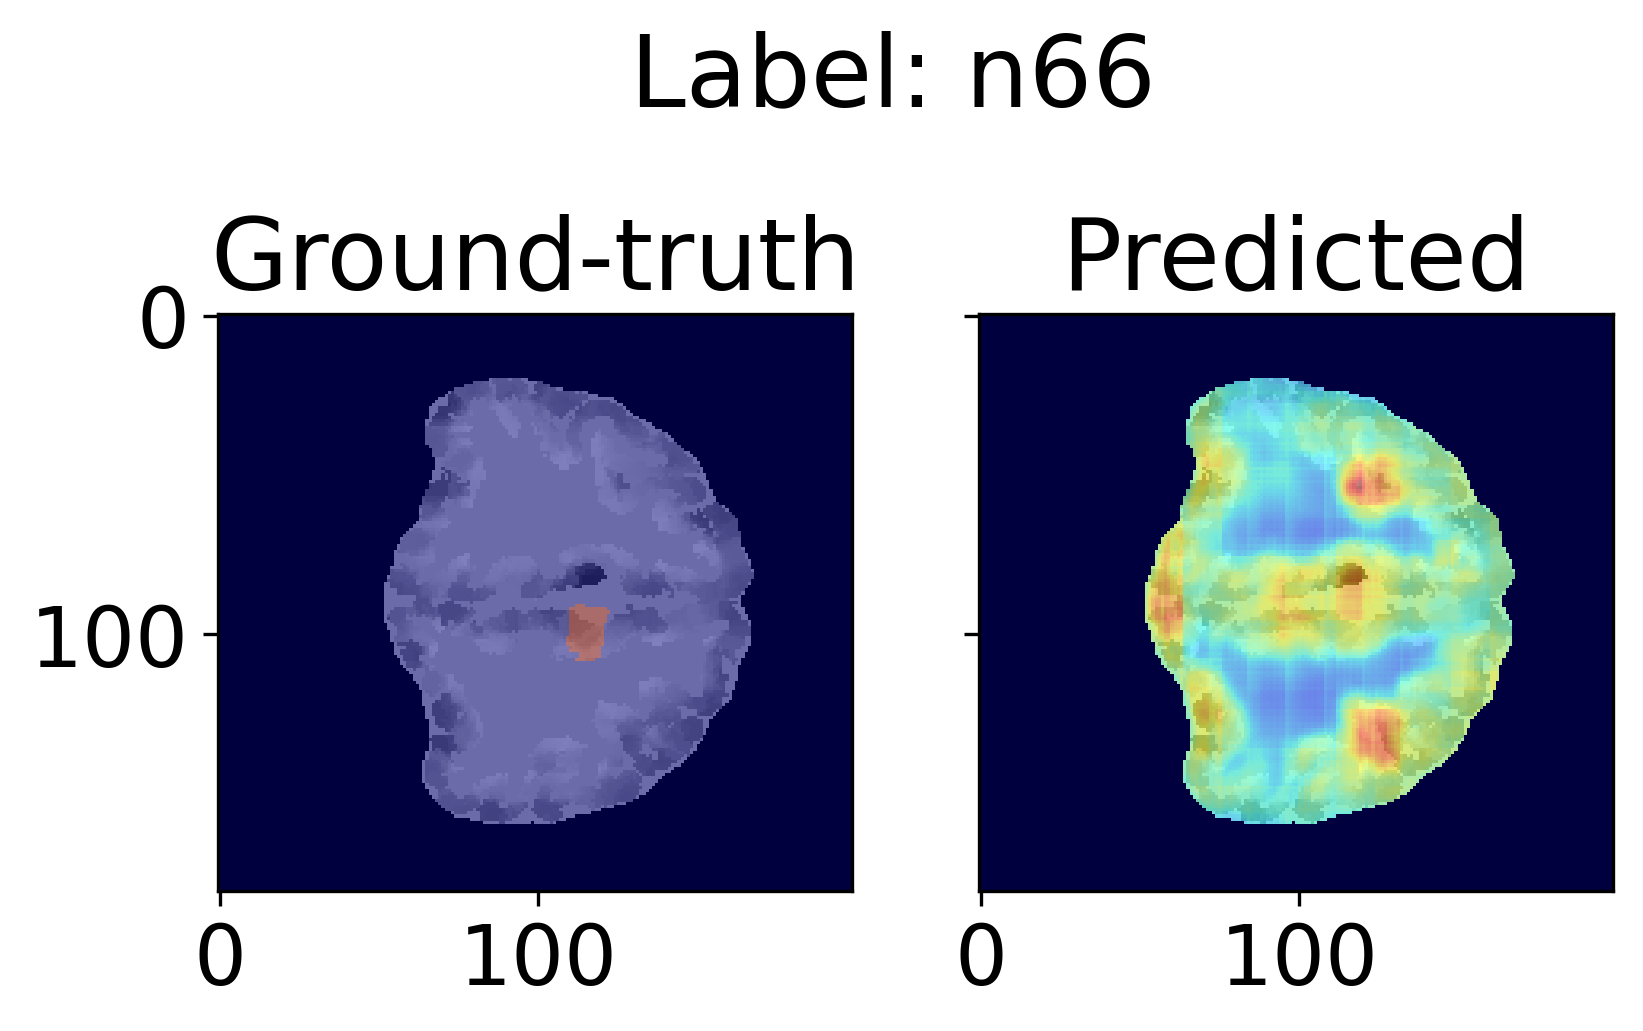

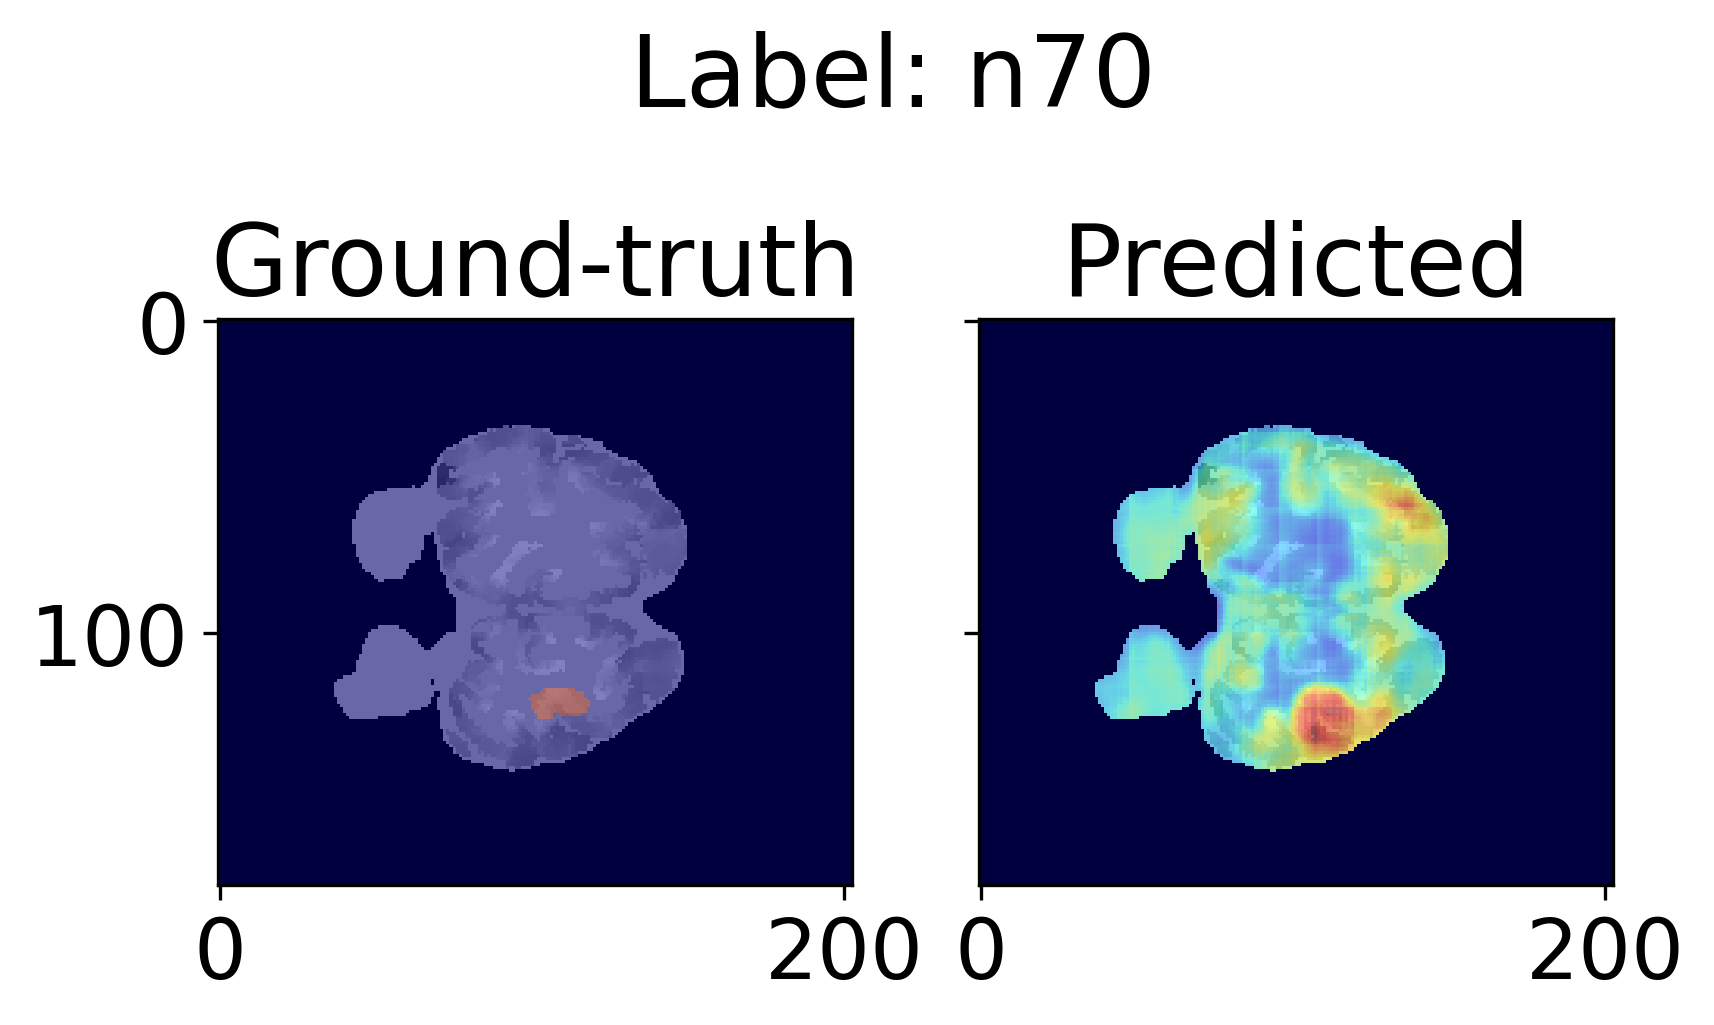

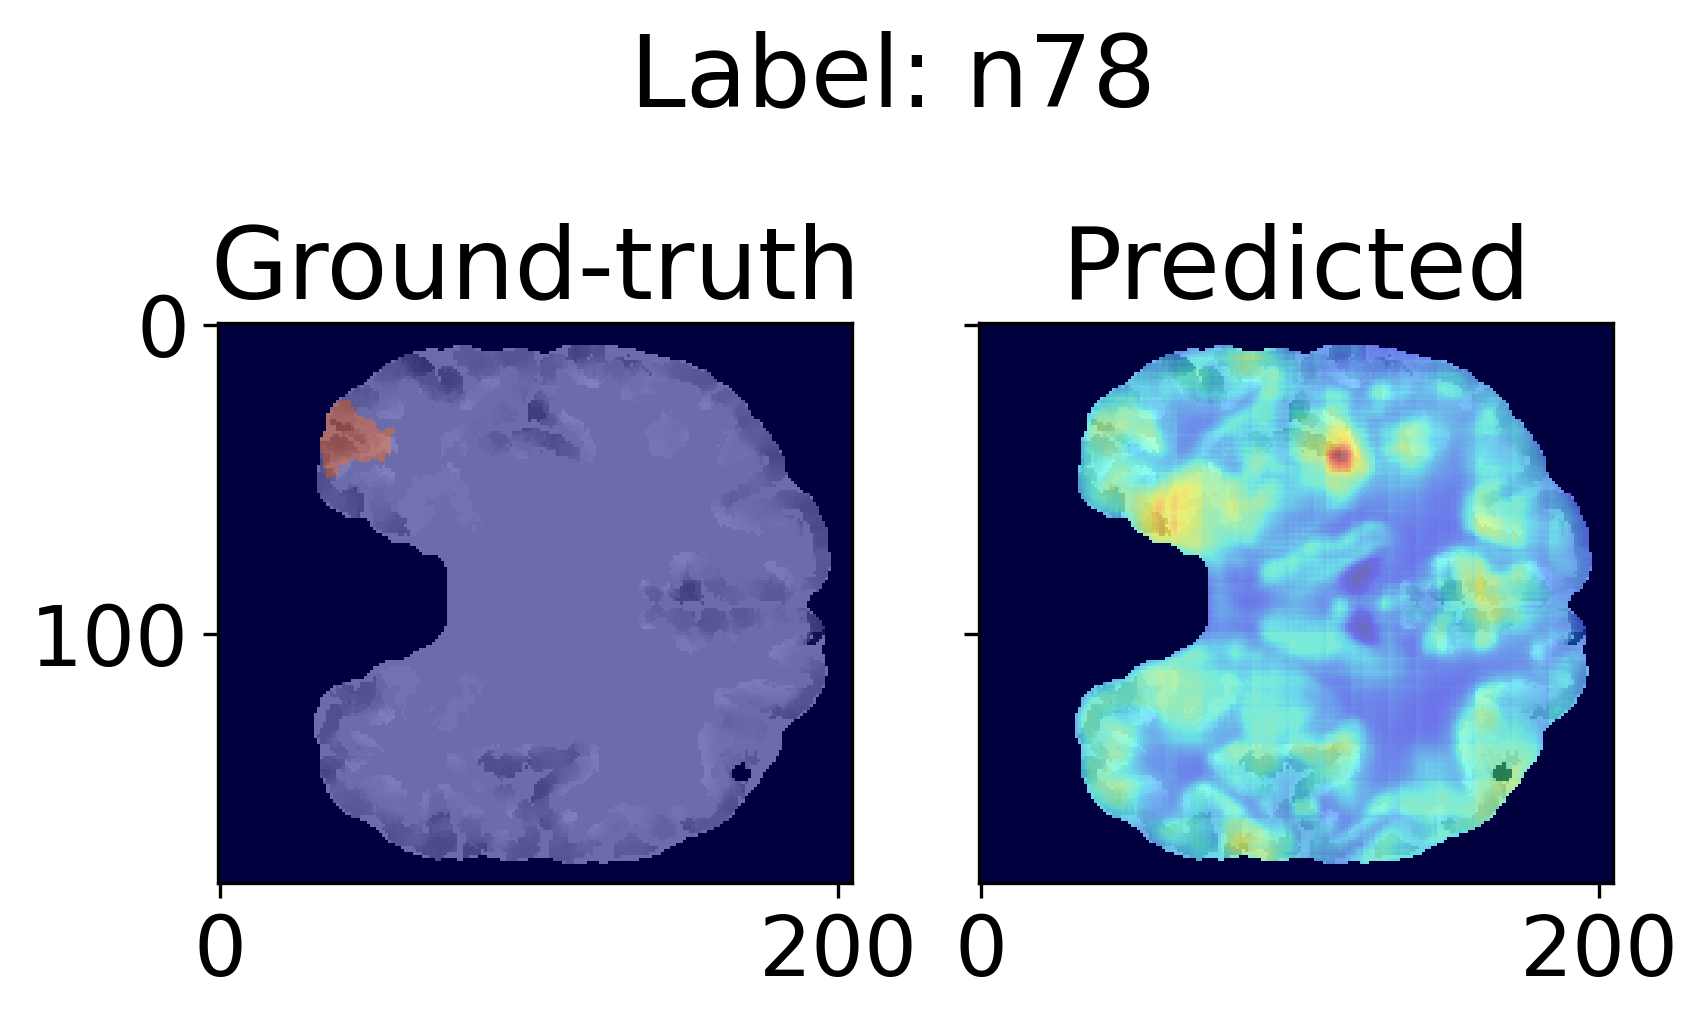

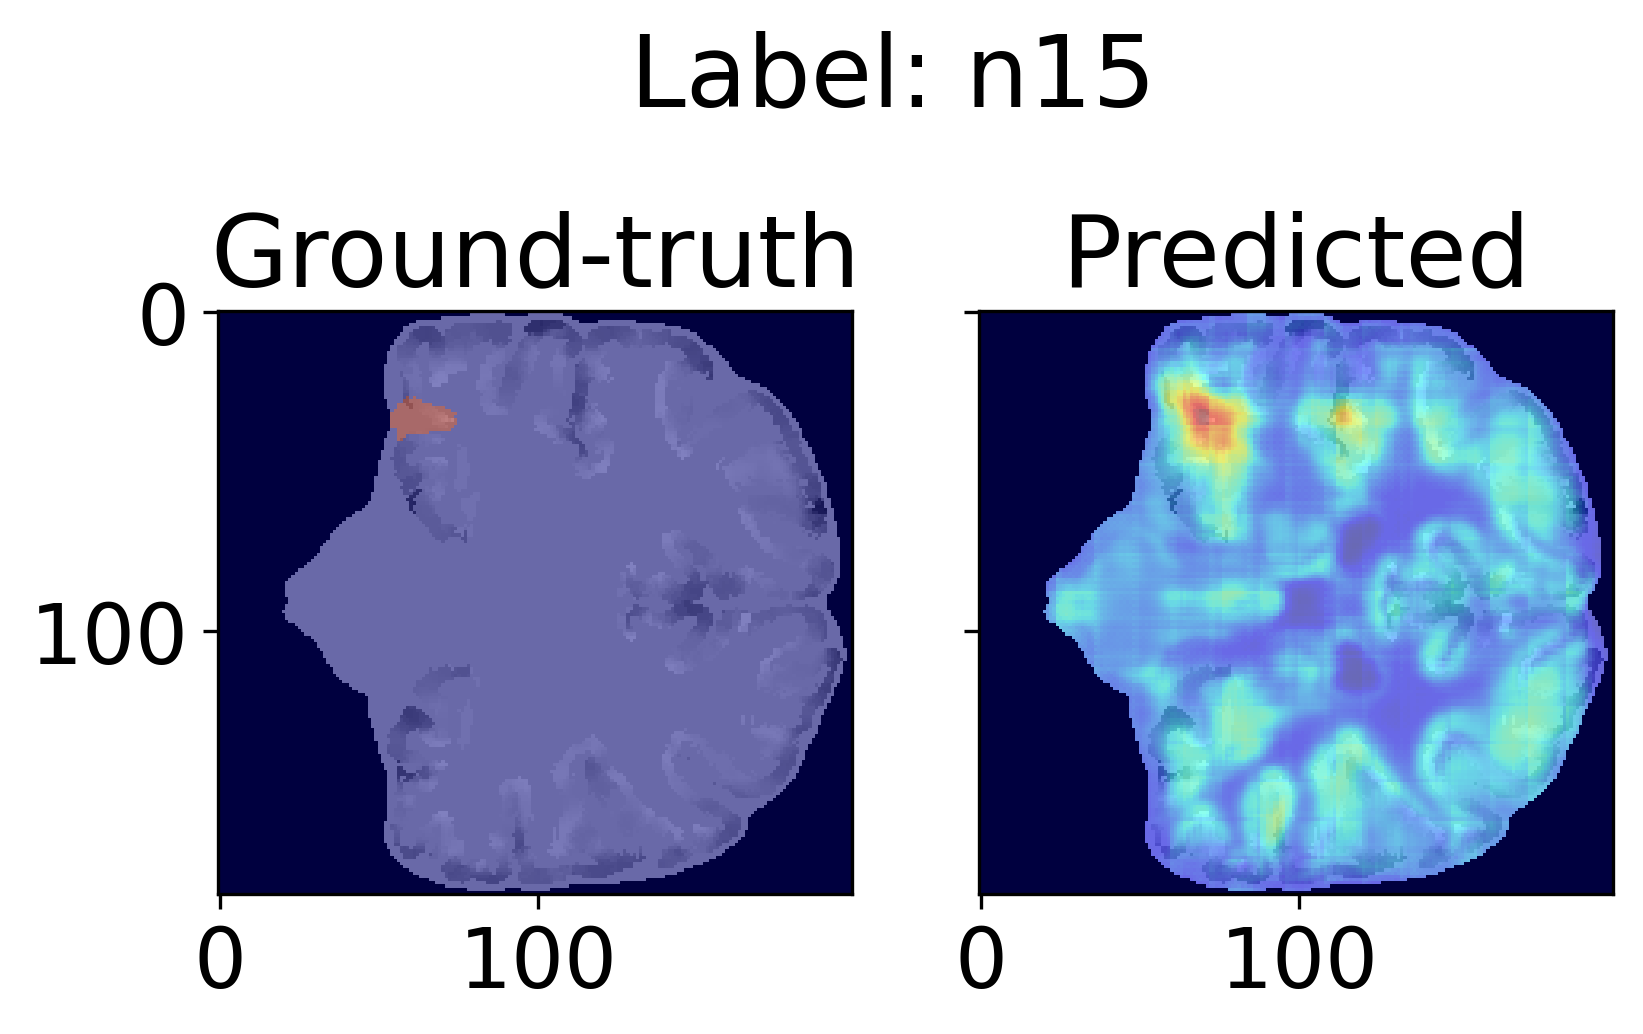

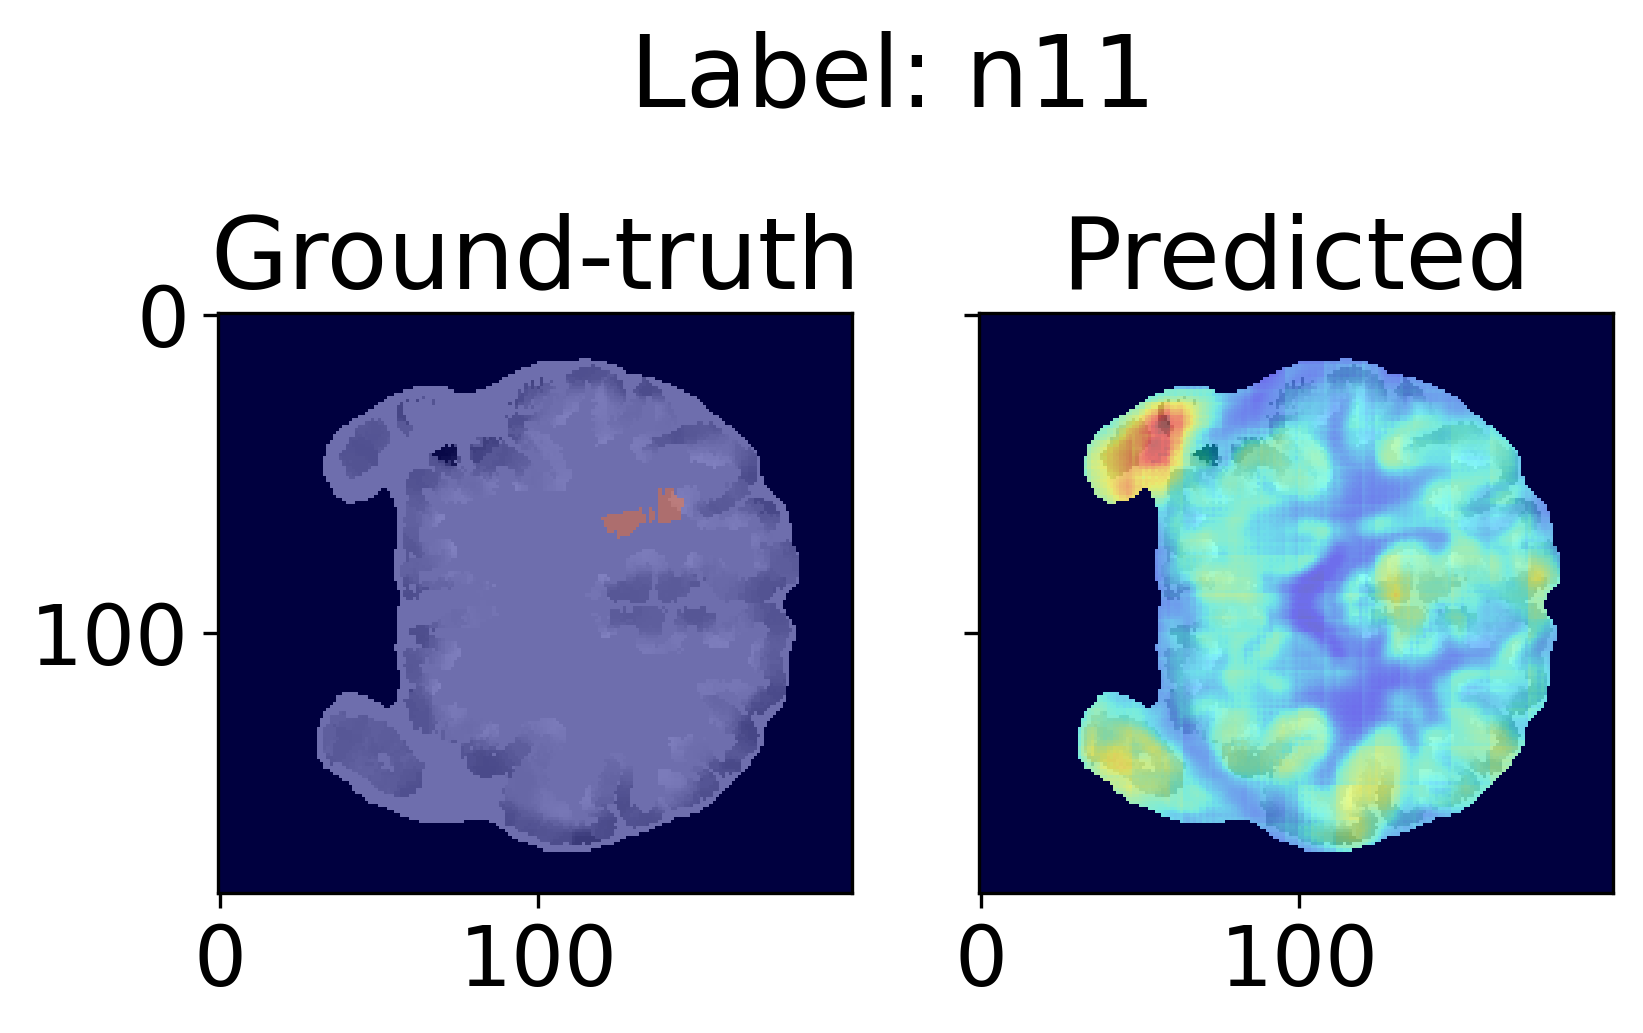

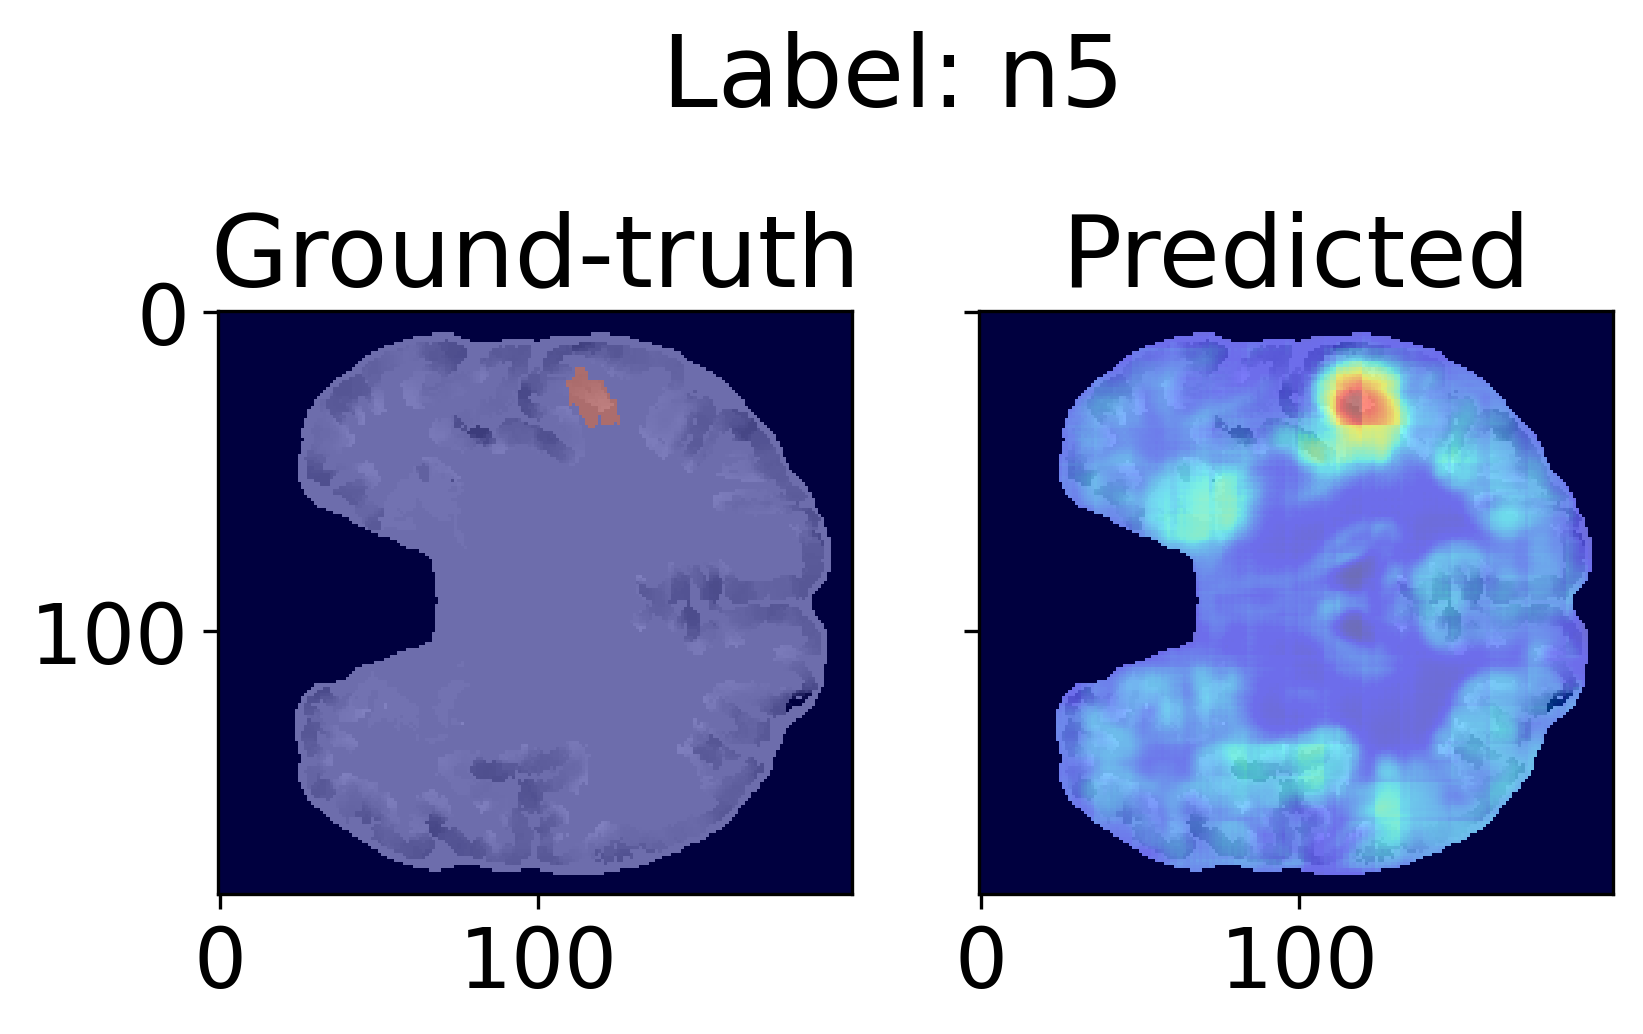

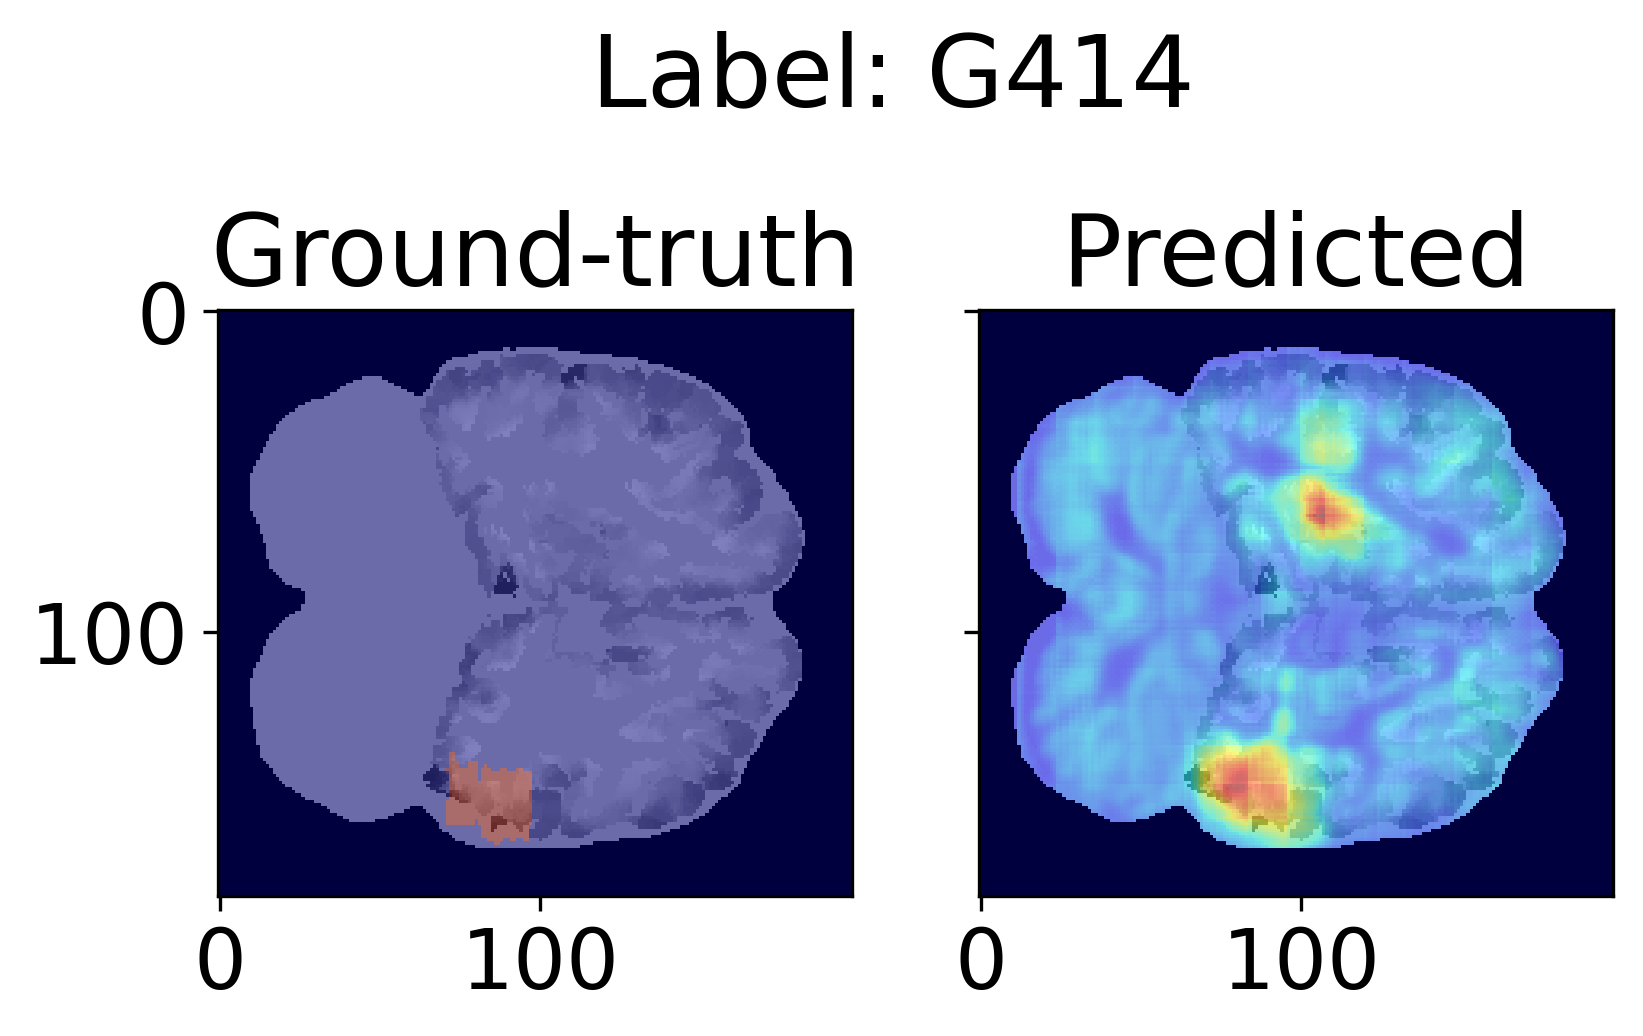

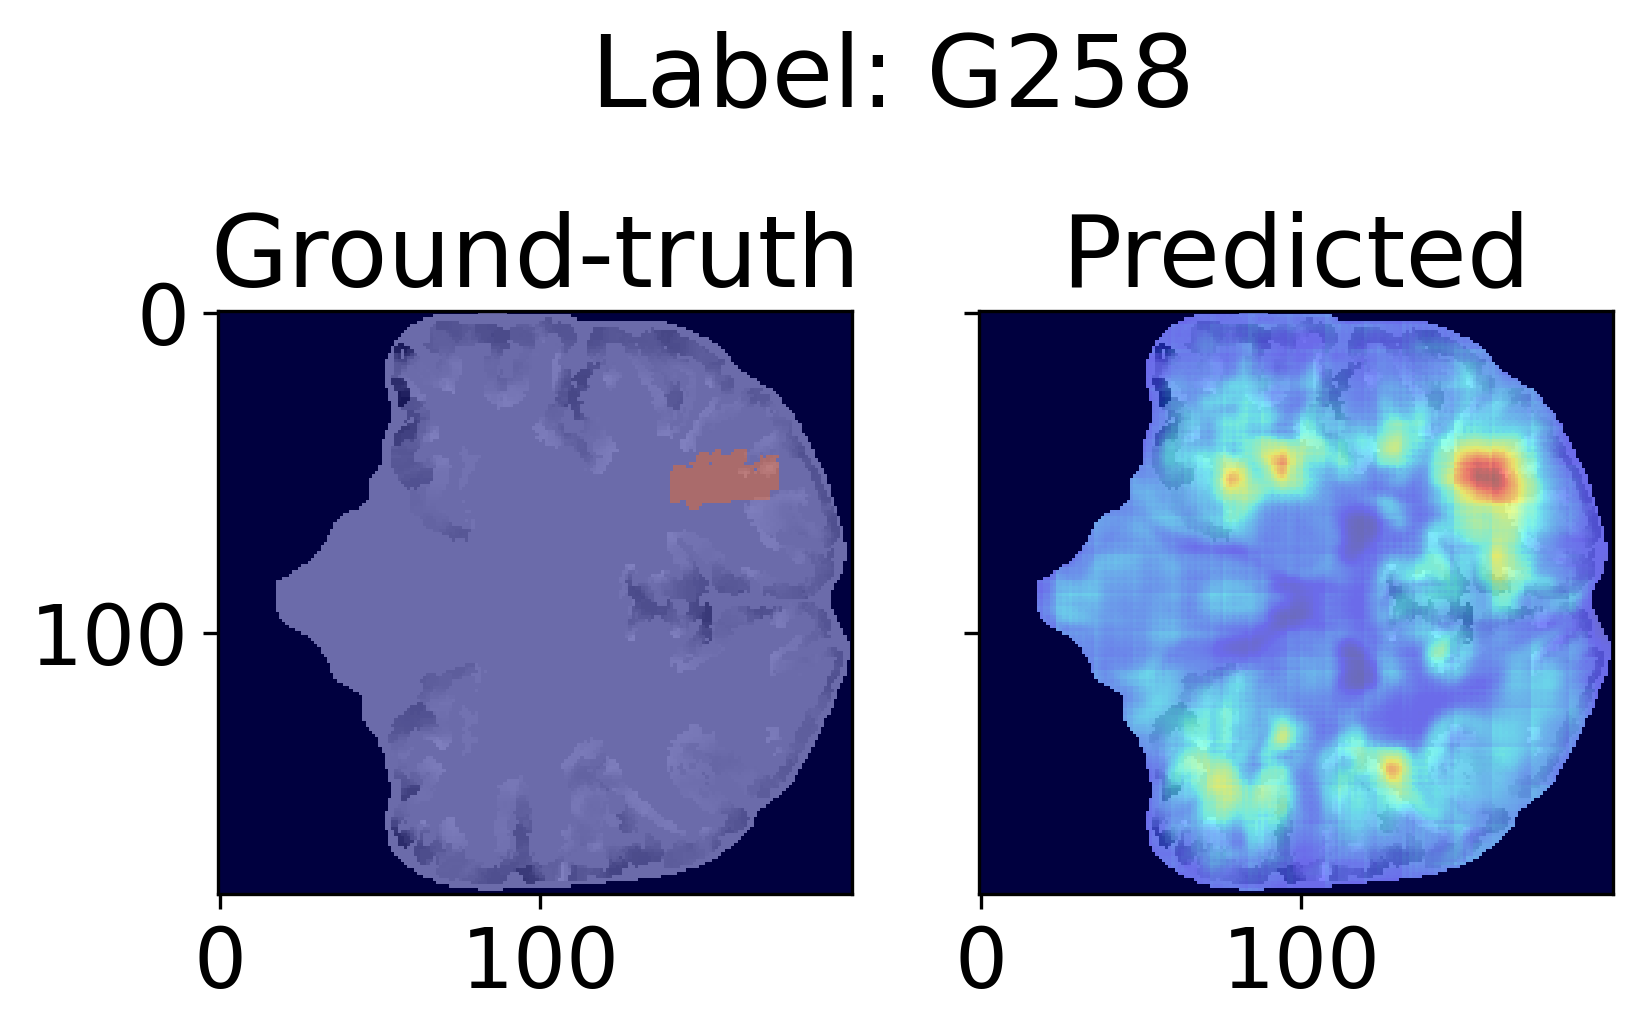

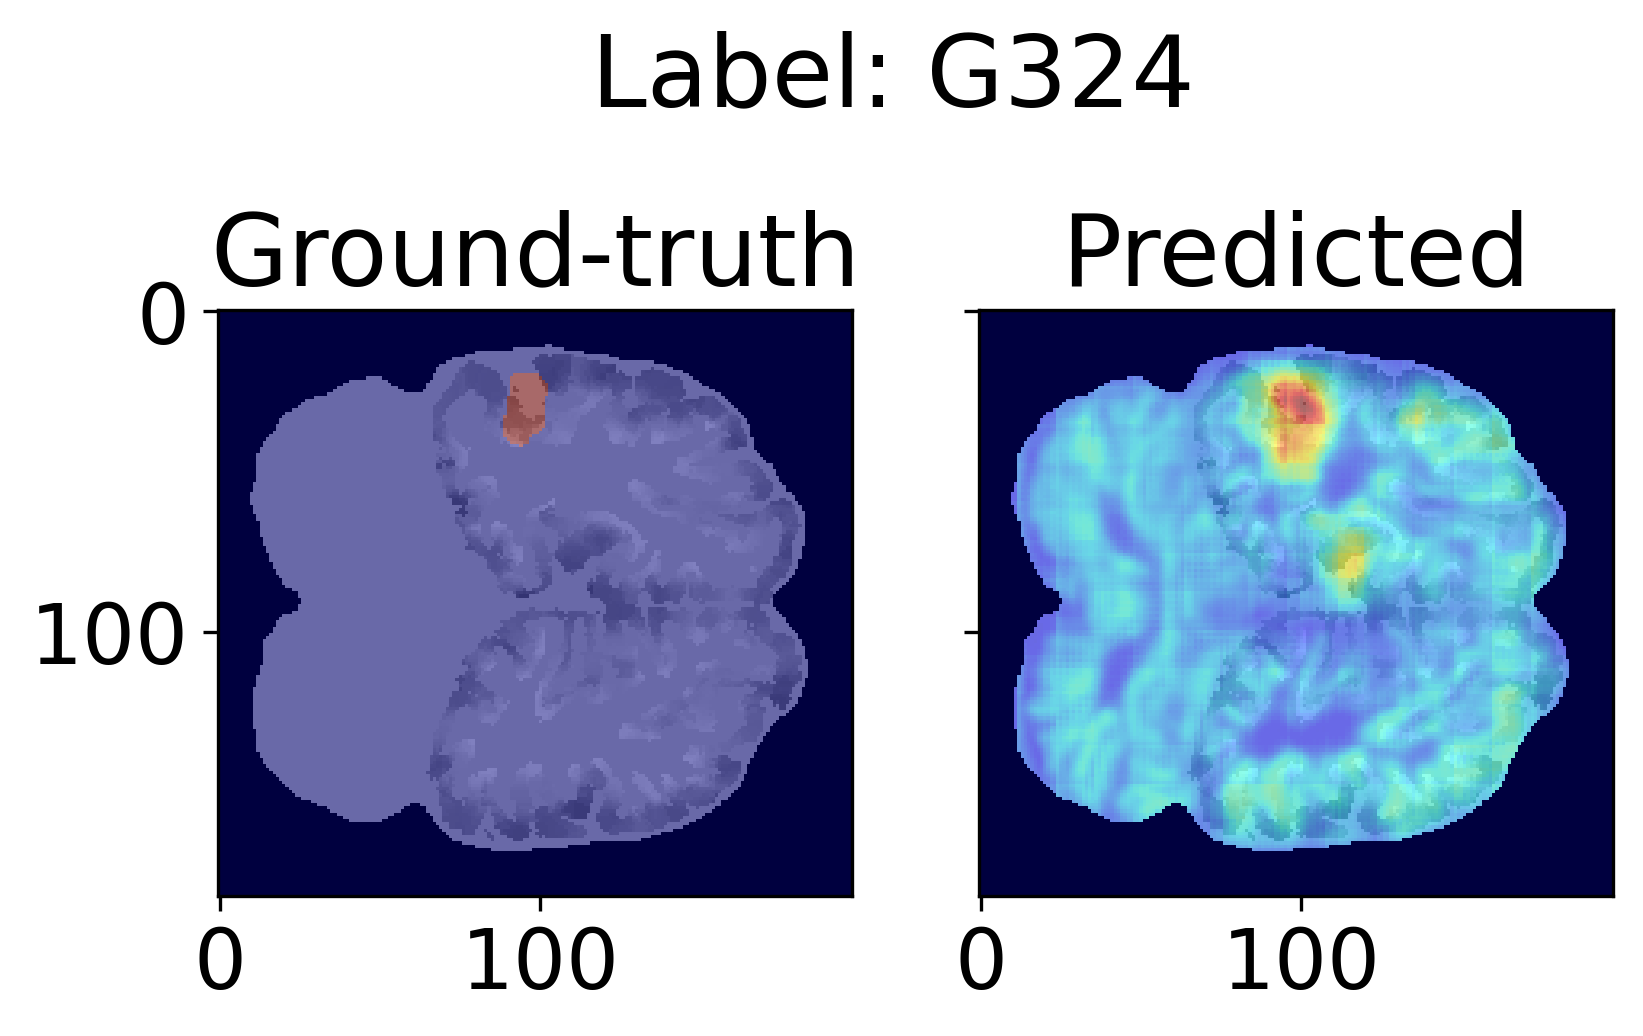

In [288]:
# label = 'G258'

for label in labels[dices < 0.2]:

    brain = brains[label][0]
    label_gt = labels_gt[label]
    label_pred = labels_predicted[label]

    fig, ax = plt.subplots(1,2, sharex=True, sharey=True, dpi=300)
    X_max, Y_max, Z_max = brain.shape

    y_slice_pos = label_gt.sum(axis=(0,-1)).argmax()

    brain_slice = brain[:,y_slice_pos,:]
    ax[0].imshow(brain_slice, 'gray')
    ax[0].imshow(label_gt[:,y_slice_pos,:], 'jet', interpolation='none', alpha=0.5)
    ax[0].set_title('Ground-truth')

    ax[1].imshow(brain_slice, 'gray')
    ax[1].imshow(label_pred[:,y_slice_pos,:], 'jet', interpolation='none', alpha=0.5)
    ax[1].set_title('Predicted')

    fig.suptitle(f'Label: {label}')

    # plt.colorbar()

    plt.show()

# Visualize patches

In [31]:
torch.tensor([0.]).mean()

tensor(0.)

In [34]:
torch.pow(torch.tensor([]), 1.37)

tensor([])

In [173]:
label = 'G414' #'G414'
label_ind = labels.index(label)

In [174]:
brain_tensor, mask_tensor, label_tensor = dataloader.dataset.__getitem__(label_ind)

In [175]:
Y_slice = label_tensor[0].sum(0).sum(-1).argmax()

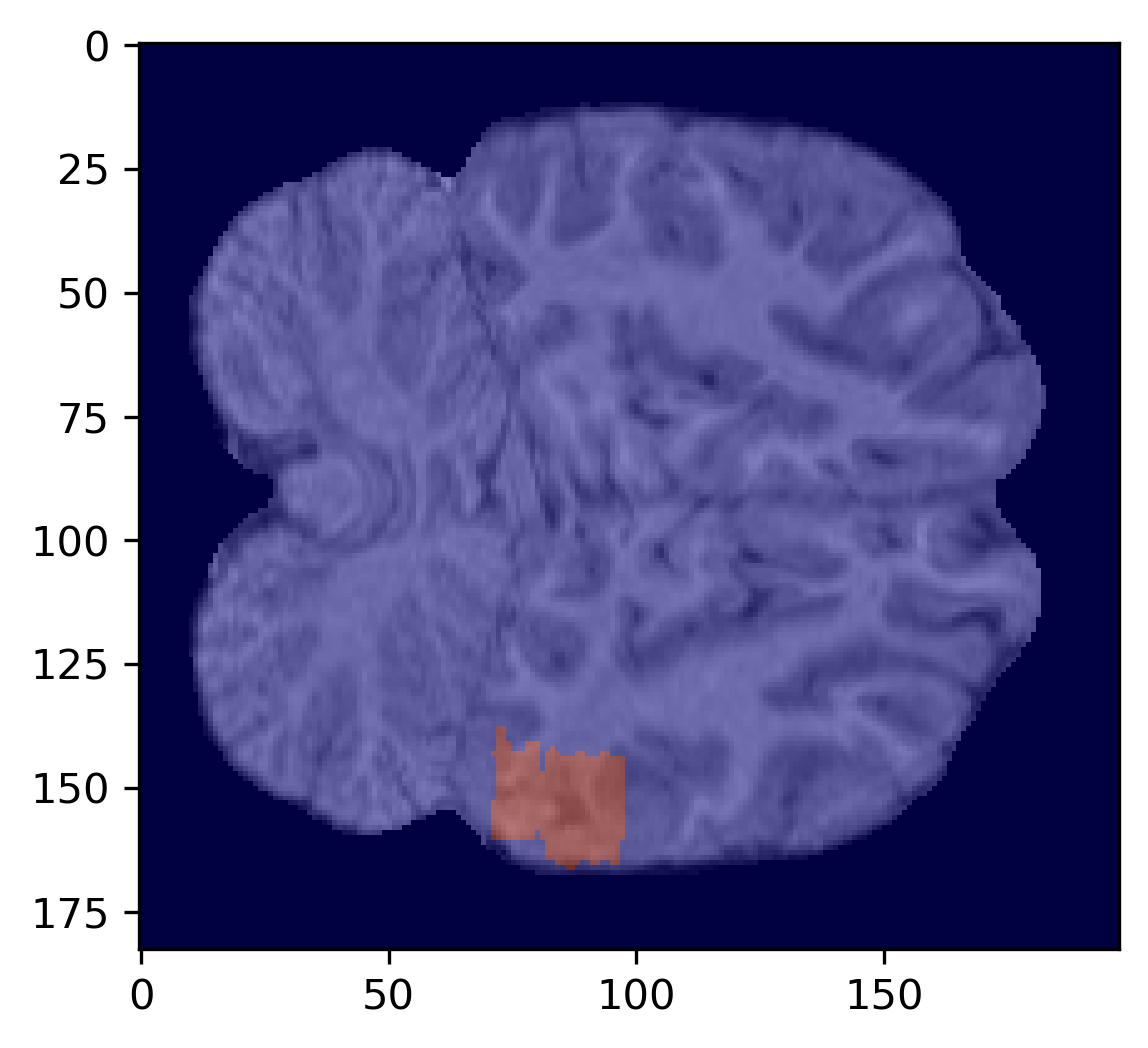

In [176]:
%matplotlib inline
plt.figure(dpi=300)
plt.imshow(brain_tensor[5,:,Y_slice,:], 'gray')
plt.imshow(label_tensor[0,:,Y_slice,:], 'jet', interpolation='none', alpha=0.5)
plt.show()

In [179]:
from datasets import BalancedSampler

In [193]:
X,Y,Z = label_tensor.shape[1:]
xyz_grid = torch.tensor(np.stack(np.meshgrid(np.arange(X)/X, np.arange(Y)/Y, np.arange(Z)/Z, indexing='ij'), 0))

subject = tio.Subject(t1=tio.ScalarImage(tensor=brain_tensor),
                      mask=tio.LabelMap(tensor=mask_tensor),
                      coords=tio.LabelMap(tensor=xyz_grid),
                      label=tio.LabelMap(tensor=label_tensor))


# augmentation
symmetry = tio.RandomFlip(axes=0) 
noise = tio.RandomNoise(std=(0,1e-2))
blur = tio.RandomBlur((0,1e-2))
affine = tio.RandomAffine(scales=(0.95, 1.05, 0.95, 1.05, 0.95, 1.05), 
                         degrees=3,
                         translation=(1,1,1),
                         center='image',
                         default_pad_value=0)
rescale = tio.RescaleIntensity(out_min_max=(0, 1))
augmentation = tio.Compose([symmetry, blur, noise, affine, rescale])
# augmentation = tio.Compose([])

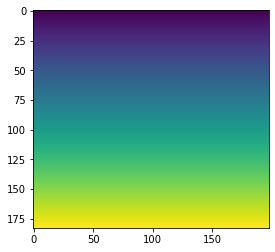

In [202]:
plt.imshow(xyz_grid[0,:,100,:])

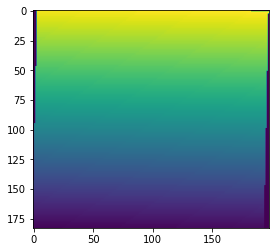

In [203]:
plt.imshow(subject_aug['coords'].tensor [0,:,100,:])

In [194]:
subject_aug = augmentation(subject)

In [189]:
(subject_aug['t1'].tensor == brain_tensor).all()

tensor(False)

In [195]:
(subject_aug['coords'].tensor == xyz_grid).all()

tensor(False)

In [196]:
subject_aug['coords'].tensor

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

In [190]:
(subject_aug['label'].tensor == label_tensor).all()

tensor(False)

In [191]:
(subject_aug['mask'].tensor == mask_tensor).all()

tensor(False)

In [ ]:
# subjs = []
# for i in tqdm(range(4)):
#     subjs.append(augmentation(subject))

In [155]:
subject['label'].tensor.shape

torch.Size([1, 183, 235, 198])

In [156]:
brain_aug.shape

torch.Size([183, 235, 198])

In [157]:
y_split, label_aug.shape

(tensor(51), torch.Size([183, 235, 198]))

In [162]:
mask_aug.uniqu

tensor([0., 1.])

In [167]:
(brain_aug*mask_aug == brain_aug).all()

tensor(True)

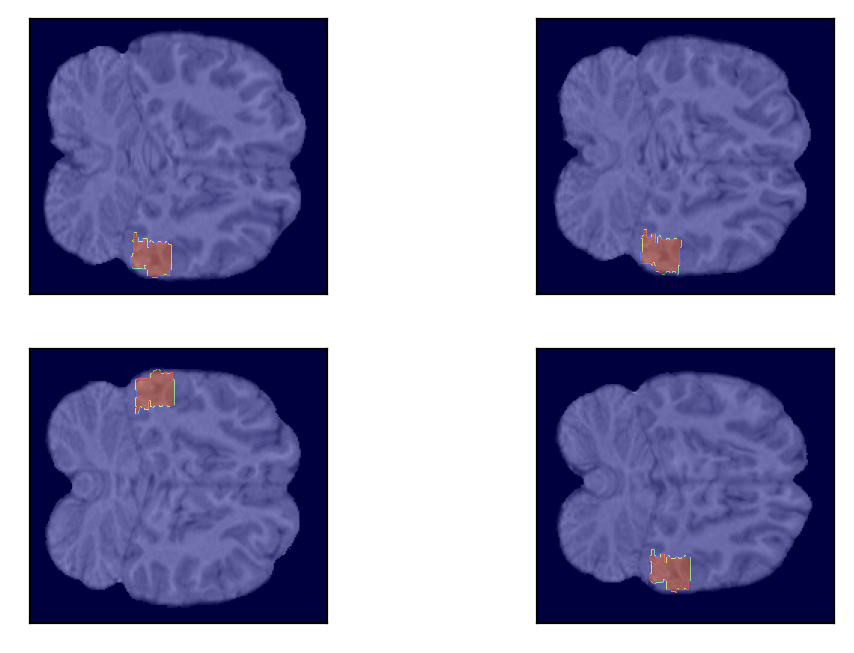

In [158]:
%matplotlib inline

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, dpi=200)
axes = axes.flatten()

for i, subj in enumerate(subjs):
    
    mask_aug = subj['mask'].tensor[0]
    brain_aug = subj['t1'].tensor[5] * mask_aug
    label_aug = subj['label'].tensor[0] * mask_aug
    
    y_split = label_aug.sum(dim=(0,-1)).argmax()
    
    axes[i].imshow(brain_aug[:,y_split,:], 'gray')
    axes[i].imshow(label_aug[:,y_split,:], 'jet', alpha=0.5)
    plt.xticks([])
    plt.yticks([])
            
plt.show()


In [212]:
subject_aug['t1'].keys()

dict_keys(['data', 'affine', 'path', 'stem', 'type'])

In [220]:
subject_aug['t1'].set_data()

TypeError: set_data() missing 1 required positional argument: 'tensor'

In [61]:
brain_tensor_aug = subject_aug['t1'].set_data()
label_tensor_aug = subject_aug['label'].tensor

In [62]:
brain_tensor_aug.shape

torch.Size([11, 183, 235, 198])

In [63]:
config.dataset.features

['curv',
 'sulc',
 'thickness',
 'bT1',
 'bT2',
 'T1w',
 'CSF',
 'GM',
 'WM',
 'cr',
 'entropy']

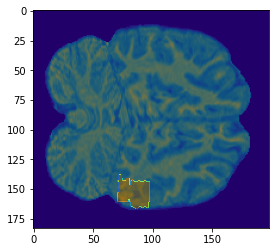

In [77]:
%matplotlib inline
plt.imshow(brain_tensor_aug[5,:,Y_slice,:])
plt.imshow(label_tensor_aug[0,:,Y_slice,:], 'jet', alpha=0.5)

In [65]:
brain_tensor_aug_Y = brain_tensor_aug.mean(dim=-2)

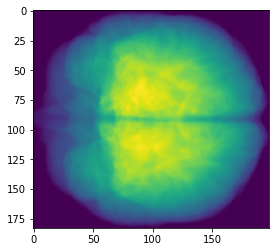

In [66]:
plt.imshow(brain_tensor_aug_Y[5])

# Balanced sampler

In [69]:
from datasets import BalancedSampler

In [94]:
label_ratio = config.dataset.label_ratio
patches_per_brain = config.dataset.patches_per_brain
patch_batch_size = config.dataset.patch_batch_size
patch_size = config.dataset.patch_size

patch_loader = BalancedSampler(subject, 
                                patch_size, 
                                patches_per_brain, 
                                patch_batch_size, 
                                label_ratio=label_ratio)

In [97]:
targets.sum(dim=(1,2,3,4))

tensor([    0.,     0., 15170., 10016.,     0., 15182.,     0., 15145.])

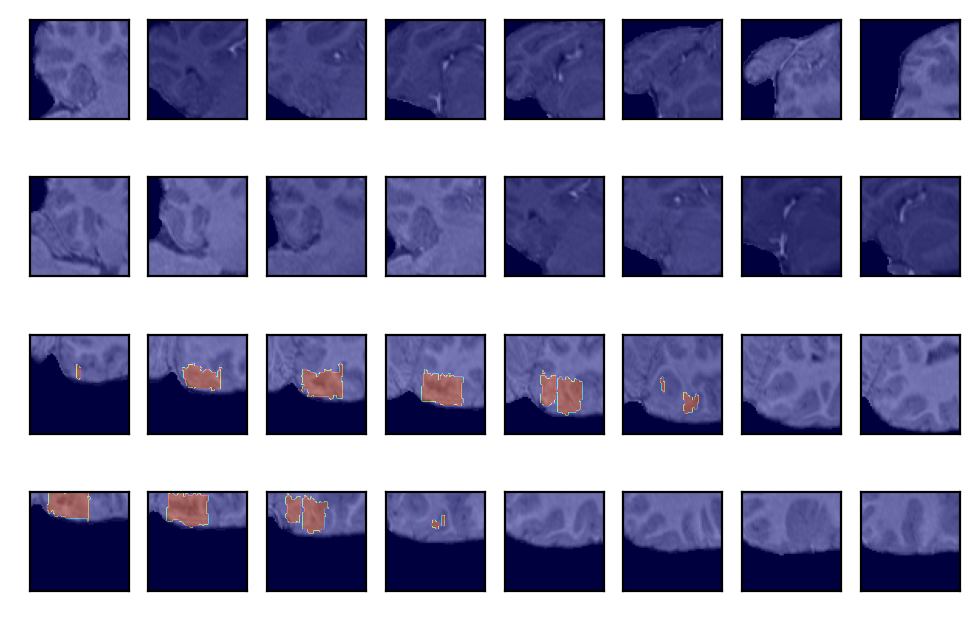

In [96]:
%matplotlib inline
for patch_i, patches_batch in enumerate(patch_loader):
    inputs, targets = patches_batch
    
    fig, axes = plt.subplots(nrows=patch_batch_size//2, ncols=patch_size//8, sharex=True, sharey=True, dpi=200)
    for i in range(patch_batch_size//2) :
        for j in range(patch_size//8):
            axes[i,j].imshow(inputs[i,5,:,j*8,:], 'gray')
            axes[i,j].imshow(targets[i,0,:,j*8,:], 'jet', alpha=0.5)
            plt.xticks([])
            plt.yticks([])
            
    plt.show()
    
    
    break

# Grid sampler

In [ ]:
patch_overlap = 0.2
pov = int(patch_size*patch_overlap) # take high overlap to avoid missing
if pov%2!=0:
    pov+=1
    
grid_sampler = tio.inference.GridSampler(subject_aug, patch_size, pov)

patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=patch_batch_size, shuffle=True)
aggregator_brain = tio.inference.GridAggregator(grid_sampler, overlap_mode='average')
aggregator_labels = tio.inference.GridAggregator(grid_sampler, overlap_mode='average')

In [ ]:
########################
# ITERATE OVER PATCHES #
########################
examples = []
print(f'Iterating for {label}, {len(patch_loader)}')
for patch_i, patches_batch in tqdm(enumerate(patch_loader)):

    inputs = patches_batch['t1'][tio.DATA] # [bs,C,p,p,p]
    targets = patches_batch['label'][tio.DATA] # [bs,1,p,p,p]
    
    examples.append(targets.sum((-1,-2,-3,-4)) > 0)

    locations = patches_batch[tio.LOCATION]
    # casting back to patch
    aggregator_brain.add_batch(inputs, locations)
    aggregator_labels.add_batch(targets, locations)    
    
examples = torch.cat(examples).type(torch.int)

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(nrows=patch_batch_size, ncols=patch_size//4, sharex=True, sharey=True, dpi=200)
for i in range(patch_batch_size) :
    for j in range(patch_size//4):
        axes[i,j].imshow(inputs[i,0,:,j*4,:])
        axes[i,j].imshow(targets[i,0,:,j*4,:], alpha=0.5)
        
#         axes.set_xticks([])
#         axes.set_yticks([])
        
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.4, 
#                     hspace=0.4)
plt.show()

In [129]:
brain_tensor_agg = aggregator_brain.get_output_tensor()
label_tensor_agg = aggregator_labels.get_output_tensor()

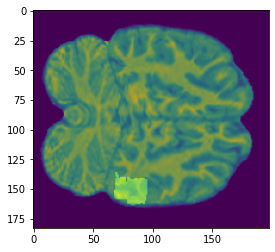

In [130]:
%matplotlib inline
plt.imshow(brain_tensor_agg[0,:,Y_slice,:])
plt.imshow(label_tensor_agg[0,:,Y_slice,:], alpha=0.3)

In [131]:
(brain_tensor_agg - brain_tensor_aug).abs().max()

tensor(3.1590e-06)

# Use CRF

In [60]:
label = 'n11' #'G414'
label_ind = labels.index(label)

In [61]:
brain_tensor, mask_tensor, label_tensor = dataloader.dataset.__getitem__(label_ind)

In [59]:
import denseCRF3D

def densecrf3d(I, P, param):
    """
    input parameters:
        I: a numpy array of shape [D, H, W, C], where C is the channel number
           type of I should be np.uint8, and the values are in [0, 255]
        P: a probability map of shape [D, H, W, L], where L is the number of classes
           type of P should be np.float32
        param: a tuple giving parameters of CRF. see the following two examples for details.
    """
    return denseCRF3D.densecrf3d(I, P, param)


dense_crf_param = {}
dense_crf_param['MaxIterations'] = 1.0 #
dense_crf_param['PosW'] = 2.0 #
dense_crf_param['PosRStd'] = 1
dense_crf_param['PosCStd'] = 1
dense_crf_param['PosZStd'] = 1
dense_crf_param['BilateralW'] = 1.0
dense_crf_param['BilateralRStd'] = 1.0
dense_crf_param['BilateralCStd'] = 1.0
dense_crf_param['BilateralZStd'] = 1.0
dense_crf_param['ModalityNum'] = 1
dense_crf_param['BilateralModsStds'] = (1.0,)

brain_prep = (np.expand_dims(brain_tensor.numpy(),-1)*255).astype('uint8')
label_prep = np.stack([1.0 - label_tensor.numpy(), label_tensor.numpy()], axis=-1)

label_crf = densecrf3d(brain_prep, label_prep, dense_crf_param)

NameError: name 'brain' is not defined

In [38]:
# plt.ioff()
# camera = video(brain,
#                label_crf, 
#               n_slides=128)
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation

In [41]:
label_gt.sum()

218.0

In [40]:
label_crf.sum()

4177

In [39]:
DiceScoreBinary(to_tensor(label_crf), 
                to_tensor(label_gt))

tensor(0.)

# Features distributions

In [183]:
true_masks_bool = true_masks[ind].astype(bool)
features = set(config.dataset.features) - {'label', 'mask'}

references_dist = {}
target_dist = {}
js_dict = {}

for i,f in enumerate(features):
    
    b = brains[ind][i]
    target_dist[f] = b[true_masks_bool]
    references_dist[f] = b.flatten()
    
    hist_ref, _ = np.histogram(references_dist[f], range=(0,1), bins=100)
    hist_ref = hist_ref / hist_ref.sum()
    
    hist_targ, _ = np.histogram(target_dist[f], range=(0,1), bins=100)
    hist_targ = hist_targ / hist_targ.sum()
    
    js_dict[f] = jensenshannon(hist_ref, hist_targ)

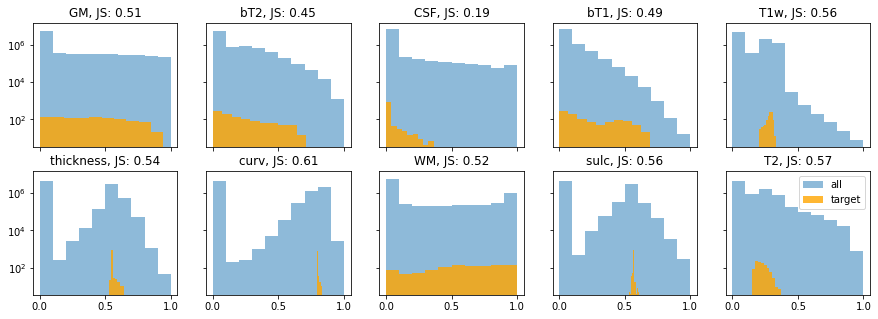

In [184]:
plt.ion()

fig,axes = plt.subplots(ncols=5,nrows=2, figsize=(15,5), sharex=True, sharey=True)

for i,(f,ax) in enumerate(zip(features, axes.flatten())):
    ax.hist(references_dist[f],alpha=0.5, label='all')
    ax.hist(target_dist[f],color='orange', alpha=0.8, label='target')
    ax.set_yscale('log')
    js = np.round(js_dict[f], 2)
    ax.set_title(f'{f}, JS: {js}')
plt.legend()
plt.show()